Last article, I gave my basic reasons for pursuing a research project into the changing demographics of the slave trade in the Americas. This was very broad, and very vague. However, now I am about to plunge into locating the necessary data to reconstruct the history I wish to reconstruct. And already I am running into technical issues. 

The archive I want to use was created 22 years ago, back when Microsoft was the preeminent provider of consumer computer products. Everything is saved as a .dbf database file, with .sav, .sps and other files used to port it to an SPSS application. I had never heard of SPSS before this project. It's a proprietary system currently owned by IBM and used heavily in the GIS community. Opening this type of layered database file in a modern environment is complicated. Microsoft has a deprecated product, Visual FoxPro, and of course there are paid products. However, I want to use a modern Jupyter notebook with Python, pandas and other standard data science tools.

I turned to the great oracle, Google, to find out how to open a .dbf file in Jupyter. There is a fairly well known package, PySal, that seemed ideal. Unfortunately, I am using Python 3.8. Pysal is dependent on a package called Rasterio, which in turn is dependent on a set of C libraries called GDAL. And here is where I ran into issues. GDAL does not, for some reason, edit its path environment variables on a Windows machine with Python 3.8. There are open issues with several development teams, but all are quite recent (the past year or so) and the issue is not yet fixed. While I'd love to use a Linux machine, at the moment I'm stuck with Windows.

So I am going to have to sacrifice the convenience of Pysal and turn to a more hacked together solution. Python comes with a dbfread library. It is going to take some work to get dbfread into Pandas, but hopefully not too much.

In [2]:
import pandas as pd

from dbfread import DBF

# Need this later on for data cleaning
import numpy as np
import datetime
import scipy as sc
from statsmodels.graphics.gofplots import qqplot

# Chart visualization
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


# Nearest Neighbor Algorithm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import plotly.graph_objects as go
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import statistics

[]

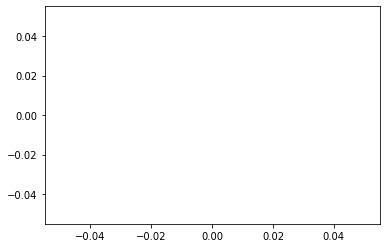

In [3]:
plt.plot()

Above, I imported Pandas. Pandas is perhaps the most popular data science package for Python and is extremely useful. I've used some of its competitors, especially Turi, and Pandas is both better documented and more supported. It does have some strange quirks, such as its odd use of zero indexing, but overall is a fun package to use.

Notice I'm also using dbfread. I'm using a script form the documentation at https://dbfread.readthedocs.io/en/latest/exporting_data.html. Please be nice to me processor gods, I just want a dataframe.

In [4]:
dbf = DBF('SLAVE.DBF')

Let's try to convert the .dbf database into a Pandas dataframe. I'm going to use Pandass' inbuilt DataFrame function because it will continue to be updated with Pandas' development. It is important to note that dbfread is only a somewhat maintained library. After parsing the source code, I noticed a lot of development is still needed. This would come back to bite me as I worked with this project. Per dbfread's documentation, we also need to pass an iterable form of the dbf file we created above. Below is the single line of code that nearly destroyed my sanity.

In [5]:
df = pd.DataFrame(iter(dbf))

Originally, this errored. And it errored in the most bizarre way. It was throwing errors about float numbers and integers with full stops. I was very confused and google didn't help much. In fact, most people just ended up editing their data file. I do not have the ability to open a dbf file, nor did I really want to open a file, edit it however many times, and close it again. So, I opened the source code of dbfread to the line that triggered the exception. Below I have a copy of the exception, lovingly recreated for you after I fixed it. Notice all the nonsense about integers and floats and b'.'.

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
c:\users\casti\appdata\local\programs\python\python38\lib\site-packages\dbfread\field_parser.py in parseN(self, field, data)
    179         try:
--> 180             return int(data)
    181         except ValueError:

ValueError: invalid literal for int() with base 10: b'.'

***Edited for clarity***

c:\users\casti\appdata\local\programs\python\python38\lib\site-packages\dbfread\field_parser.py in parseN(self, field, data)
    184             else:
    185                 # Account for , in numeric fields
--> 186                 return float(data.replace(b',',b'.'))
    187                 '''
    188                 if isinstance(data, float) or len(data) >= 2:

ValueError: could not convert string to float: b'.'

As I said, googling this error only turned up more people with the same issue. Since I couldn't use the package that everyone else seemed to prefer (PySal!) I decided to wade into the source code. Perhaps somewhere in the field_parser.py file I'd find a clue to fixing my code.

I didn't. Instead, I found the reason the code errored in the first place. Here's some code taken directly from the fieldParser.py file in the dbfread package.

    def parseN(self, field, data):
        """
        Parse numeric field (N)

        Returns int, float or None if the field is empty.
        """
        
        # In some files * is used for padding.
        data = data.strip().strip(b'*')
        try:
            return int(data)
        except ValueError:
            if not data.strip():
                return None
            else:
                # Account for , in numeric fields
                return float(data.replace(b',',b'.'))
                
Folks, that was the entirety of the exception handling. The default case was, simply, to replace all commas with full stops and then try to convert whatever monstrosity resulted into a float. It is understandable Python didn't really want to do this. By this logic, if the number 1,234.56 was passed to the parseN method, the result would be 1.234.56. This is, obviously, neither a float nor an integer. It is an unholy creation of man. I decided to fix this.

First, I decided the final case should be the float NaN. NaN stands for, in the surreally linear logic of computer scientists, *N*ot *A* *N*umber. Get it? NaN...Not A Number. This meant that, if the code was absolutely sure we were dealing with numbers, but it kept mangling whatever it was passed, it should just insert the Pythonic equivalent of a shrug. This is probably not the best design, but short of refactoring the whole dbfreads library I thought it would work as a stopgap. The code now read:

    def parseN(self, field, data):
        """
        Parse numeric field (N)

        Returns int, float or None if the field is empty.
        """
        
        # In some files * is used for padding.
        
        data = data.strip().strip(b'*')
        try:
            return int(data)
        except ValueError:
            if not data.strip():
                return None
            else:
                # Account for , in numeric fields
                if isinstance(data, float):
                    return float(data.replace(b',', b'.')
                return float(b"NaN")
                
I don't actually know why the function needs to return a binary code. Perhaps there's a calling function somewhere in dbfreads that only accepts binary. Maybe it's a powermove on the part of the developers, who wanted to remind the computer it only speaks binary. Nonetheless, I am now returning the binary version of the float number "NaN".

This didn't quite fix my problem. Instead, I still kept getting that error about the binary full stop from earlier. It had moved on a few lines (I was inserting counters at one point to trace where in the file there were errors) but I was still having problems with this function. So I started thinking about when a number might *look* like a float but was, in fact, never meant to be such a thing. Suppose there was a field that said *0,*. This would obviously be corruption or entry error, but hey data is messy. If you called this parseN function on *0,*, it wouldn't convert to an integer, it *would* raise an exception, but would not trigger the replace method. Instead, it would turn into a float "NaN". I didn't want that data loss, even if I don't understand the data. So, I should really build a trap for such pieces of data.


    def parseN(self, field, data):
        """
        Parse numeric field (N)

        Returns int, float or None if the field is empty.
        """
        
        # In some files * is used for padding.
        data = data.strip().strip(b'*')

        try:
            return int(data)
        except ValueError:
            if not data.strip():
                return None
            else:
                # Account for , in numeric fields

                if len(data) >= 2:
                    return float(data.replace(b',',b'.'))
                return float(b'NaN')
                
See my clever little trap? I'm checking to see if the length of the data is over 2. Why? Well, I've already checked if the number is a float. If the data was *0,0* it would already be caught. But the number *1,500.0* still won't be caught. I don't want numbers that are only 1 digit long. They will easily convert to integers, unless the program is trying to pass *','* or some other crazy character as a number. I don't know enought about the program to dig through why it is trying to pass those characters, so I weed them out with the length check. Now, *1,500.0* will get the floating point conversion treatment it deserves.

I also had to make one other little edit. There was a similar problem with a datetime method. However, in this case it looks like the originaly developer forgot to add a .strip() method they clearly meant to. This is because, in the comments, they clearly indicate they intend on testing for both empty spaces *and* spaces full of zeros for a datetime column. Nonetheless, they only strip off the zeros, not the spaces. I added a clause looking for the empty spaces and now it works.

This is the end of the post. There's still a lot of work to do to make this data accessible and accurate enough for any sort of valid historical conclusions to be drawn. However, it is now loaded, the dbfread source code has been strengthened, and it's time to take a break. Somewhere, distantly, I hear a martini glass clinking.

OK, picking up where I left off. It's time to clean this data! To see what I mean, observe the following code:

In [6]:
df.dtypes

    

DOCDATE        object
YEAR            int64
DOCNO          object
NOTARY         object
CODER         float64
               ...   
ARRIVEDATE     object
FROM           object
UNBAPT        float64
VIA           float64
COMMENTS       object
Length: 114, dtype: object

While there are 114 columns to be concerned about, we need to start at the very beginning. The column DOCDATE should be a datetime object, but notice that Pandas currently only knows that this column is an object. The object dtype indicates some form of string, or a mixed type column. This tricky little clause means we are uncertain if all but one DOCDATE entries is a proper datetime object, and one is broken, or if there is a scattering of non-datetime objects.

In [7]:
df['DOCDATE'] = pd.to_datetime(df['DOCDATE'])
df['DOCDATE'].dtype

dtype('<M8[ns]')

In [8]:
df.dtypes

DOCDATE       datetime64[ns]
YEAR                   int64
DOCNO                 object
NOTARY                object
CODER                float64
                   ...      
ARRIVEDATE            object
FROM                  object
UNBAPT               float64
VIA                  float64
COMMENTS              object
Length: 114, dtype: object

Surprisingly, I was able to simply convert the DOCDATE column directly to the datetime object in Python. This indicates the DOCDATE column was, in fact, full of dates and not something else. We can continue on like this for all 114 columns. 

I'm about to do something a bit controversial. Essentially, I'm converting my YEAR column, but to an integer and not a date. My reason for this is pretty simple. I don't actually want to use the year column AS a date. Dates are for things like machine output and other artifacts from the Information Age. I'm interested in a simple number, namely the number of years in the Common Era. I may have to manipulate this data in ways that is more useful as an integer, such as finding how many years elapsed between a slaves sale and resale, etc. While there are probably functions for all of this work, for the sake of clarity I'm converting YEAR into an integer and not a date.

In [9]:
df['YEAR'].astype('int')

0         1719
1         1719
2         1719
3         1719
4         1719
          ... 
100661    1820
100662    1820
100663    1820
100664    1820
100665    1820
Name: YEAR, Length: 100666, dtype: int32

As fun as it might be to continually change each of these fields by hand, I'm the lazy sort of data analyst who believes computers were invented so I could lounge in the pool. It's time to put some good old Python into use. I know there are 114 columns. I know that I want *most* of those columns to be strings. This is because there is a lot of data that is best understood as text. Columns like NOTARY and FROM are clearly meant to be a personal name and a placename. However, there are a few that should *NOT* be strings. The column ARRIVEDATE, for instance, should always be a datetime. 
Other columns should be mostly an integer or float, except for some sort of value indicating an unknown status. The column AGE, for instance, should never be a string unless the answer is 'UNKNOWN'. While the practice of owning humans as chattel was dehumanizing in the extreme, the resale of humans did create a need for strict record keeping. Most slave ages would be known to a relatively sure degree, if they were born on a plantation. A slave newly trafficked, or perhaps resold from a more chaotic or fraudulent area, would have an unknown age. So what I need to do now is find all of the columns that *look* like they should be non-strings. If their current pandas dtype is 'object', this indicates mixed types such as a number and a string, a float and an int, or some other form of mixed up data.
So, first, I need to identify which columns have mixed types. Below I wrote some code to iterate over the dataframe, select all of the object dtypes, and return a list. I know in introductory programming courses I hated the section on list comprehensions, because they seemed to be confusing, but in a Jupyter notebook like this it really is quite handy to have all of the code on a single line.

In [10]:
object_col = [col for col in df.columns if df[col].dtype == 'object']

Now that I know precisely what columns have an object dtype, I need to inspect the list manually. I don't know of an automatic way to figure out what columns shouldn't have strings. Perhaps when the singularity comes, this will be a side effect. Of course, it doesn't seem like Skynet or whatever Facebook means by Meta will care much for human history.

So, should the Singularity come, I'm putting in my bid as Advisor to the Singularity on History. In the meantime, I'm going to try to continue rehumanizing people who were dehumanized. And fighting the good fight against corrupt data. And drink as many ciders as possible.

To return to the point, let's see what columns might potentially need our attention.

In [11]:
object_col

['DOCNO',
 'NOTARY',
 'DATEINV',
 'DATESALE',
 'PARISH',
 'ESTATE_OF',
 'FIRSTNAME',
 'ESTATE',
 'SELLER',
 'FIRST1',
 'BUYER',
 'FIRST2',
 'NAMEXPLAIN',
 'NAME',
 'SKILLS',
 'CHARACTER',
 'SICK',
 'SPELL',
 'GROUPMEMB',
 'INVCUR',
 'SALECUR',
 'FAMILY',
 'SPNATMOM',
 'MATENAME',
 'SPELNAMATE',
 'SPNADAD',
 'SPNAGM',
 'SPNAGRPA',
 'CAPTAIN',
 'SHIP',
 'ARRIVEDATE',
 'FROM',
 'COMMENTS']

From this list, I have identified only a few columns that clearly require an integer, float or date. 'DOCNO' is, I'm fairly certain, going to be a numeric code for the documents. It is also possible it is an alphanumeric code, but given the small(ish) number of documents and age of the project I suspect it is numeric. However, ARRIVEDATE, AGE, DATESALE and DATEINV all seem like they should not be strings. There are a few columns that I'm just not sure about. What is SALECUR? Or INVCUR? Since I don't know, I'll have to inspect the columns manually after I'm done this work. But for now, it is import to get as many columns as possible finished.
Below I will make a list of columns I don't think are strings. I will call this, creatively, not_strings. I can add to it later using list methods, and delete if I'm mistaken. I am also using a list comprehension to pull out the not_strings entries from the object_col list. I will call this new list, again creatively, strings.

In [214]:
not_strings = ['DOCNO',
               'ARRIVEDATE',
               'AGE',
               'DATESALE',
               'DATEINV',
               'CODER',
               'DEPOT',
               'LOCATION',
               'DOCTYPE',
               'MAROON',
               'REVOLTS',
               'LANGUAGE',
               'AFLANG',
               'LINGUISTIC',
               'FREE',
               'ESTFREE',
               'ESTATEPOP',
               'WENT',
               'NAMETYPE',
               'SEX',
               'RACE',
               'AGE',
               'AGECATN',
               'SKILLCAT',
               'EXPERT',
               'APPRENTICE',
               'ALITTLE',
               'SKILL2',
               'SKILL3',
               'SKILL4',
               'SKILL5',
               'CHARCAT',
               'CHARCAT2',
               'CHARCAT3',
               'SICKCAT',
               'SICK2',
               'SICK3',
               'SICK4',
               'BIRTHPL',
               'BRUT',
               'GROUP',
               'INVVALUE',
               'INVVALP',
               'SALEVALUE',
               'SALEVALP',
               'FAMILY_Y_N',
               'CHILDREN',
               'MALE',
               'FEMALE',
               'UNDER5',
               'PREGNANT',
               'MOTHER',
               'AGEMOM',
               'RACEMOM',
               'INVWMOM',
               'SOLDWMOM',
               'ORMOM',
               'MATE',
               'AGEMATE',
               'AGECATMATE',
               'RACEMATE',
               'ORIGINMATE',
               'FATHER',
               'AGEDAD',
               'RACEDAD',
               'ORDAD',
               'GRANDCHILD',
               'GRANDSONS',
               'GDAUGHTERS',
               'GRANDMA',
               'AGEGRANDMA',
               'ORGRANDMA',
               'GRANPA',
               'AGEGRANDPA',
               'ORGRANDPA',
               'EMANCIP',
               'DEAD',
               'RUNAWAY',
               'ENTERPRISE',
               'STPORT',
               'VIA',
               'ISLAMIC'
              ]

strings = [entry for entry in df if entry not in not_strings ]
dates = ['DOCDATE','ARRIVEDATE','DATESALE','DATEINV']
integers = [entries for entries in not_strings if entries not in dates]
integers.append('YEAR')
integers_and_dates = [entries for entries in integers or entries in dates]

Now that I have all of these lists floating around, it is time to actually convert things to strings. It took me awhile to figure out the current method to do this. Pandas was created as a numerical and scientific computing library. It is only recently that a better string dtype has been added. Using methods that seem obvious (to_string()) does not change the dtype. Instead, you need to use a very specific set of formats. Scouring the internet, again, is not very helpful, to the tune of, "The documentation is your best source, look at it here" https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html. Although the string datatype was first implemented in Pandas 1.0.0, there are StackOverflow posts listing incorrect methods for this conversion. ONLY use the ones in the documentation.

In [13]:
def cols_to_correct_type(list_col, type_col):
    '''
    Takes a list of columns that should be converted to a given type and converts them all.
    '''
    for entries in list_col: #iterate over my list of strings, not the entire Dataframe
        df[entries] = df[entries].astype(type_col)  


cols_to_correct_type(strings, 'string')



In [218]:
integers[0]


'DOCNO'

In [219]:
integers = integers[1:]

In [220]:
df[integers] = df[integers].fillna(-1)

In [222]:
df[integers] = df[integers].replace('UNKNOWN','-1')

In [17]:
df[strings] = df[strings].fillna('UNKNOWN')

In [18]:
df[strings] = df[strings].replace(r'\s+','UNKNOWN')

In [19]:
df['DOCDATE'].isna().any()

False

In [20]:
df[dates] = df[dates].fillna(df['DOCDATE'])

In [21]:
for index, value in df.isna().any().items():
    if value:
        print(index)

DATEINV
DATESALE
ARRIVEDATE


In [22]:
'ARRIVEDATE' in dates

True

In [23]:
df['ARRIVEDATE'] = df['ARRIVEDATE'].fillna(df['DOCDATE'])
df['ARRIVEDATE'].isna().any()

False

In [24]:
for col in strings:
    offenders = []
    if df[col].isin(['']).any():
        offenders.append(col)
print(offenders)


['COMMENTS']


In [25]:
df = df.drop(columns=['COMMENTS'])

In [26]:
# Test to make sure I've successfully added strings
df.dtypes

DOCDATE        string
YEAR           string
DOCNO          object
NOTARY         string
CODER         float64
               ...   
SHIP           string
ARRIVEDATE     object
FROM           string
UNBAPT         string
VIA           float64
Length: 113, dtype: object

As you can see, I have successfully changed the vast majority of the columns to strings. However, I'm not done yet. What about those five columns with mixed types?

In [27]:
dates

['DOCDATE', 'ARRIVEDATE', 'DATESALE', 'DATEINV']

Yeah, those. Let's fix those up. I suspect DOCNO should be a set of integers, but I'm not sure.

In [28]:
df['DOCNO']

0               
1               
2               
3               
4               
           ...  
100661      3754
100662       223
100663       224
100664       363
100665       363
Name: DOCNO, Length: 100666, dtype: object

In [29]:
df['DOCNO'] = df['DOCNO'].fillna('-1')

In [30]:
df['DOCNO'].isna().any()

False

In [31]:
df['DOCNO']

0               
1               
2               
3               
4               
           ...  
100661      3754
100662       223
100663       224
100664       363
100665       363
Name: DOCNO, Length: 100666, dtype: object

In [32]:
df['DOCNO'] = df['DOCNO'].replace(''.strip(),-1,regex=True)

In [33]:
df['DOCNO']

0             -1
1             -1
2             -1
3             -1
4             -1
           ...  
100661      3754
100662       223
100663       224
100664       363
100665       363
Name: DOCNO, Length: 100666, dtype: object

Looks pretty integery to me. Let's try to convert.

df['DOCNO'] = df['DOCNO'].astype('int')

Ooooh hooo hooo. An error. What might this beastie be?

ValueError: invalid literal for int() with base 10: ''

Looks like there are some emtpy spaces and/or someone left a blank in the column. Luckily, this is Pandas. It was made for precisely this moment. I could, theoretically, write a for loop that would replace *''* with, well, anything I want. However, all I really need is to call Pandas' function *replace* and someone much better at optimization will take care of the matter for me.

First, I want Pandas to recognize empty spaces as a missing value. Basically, Pandas would really prefer that everything was just numbers. The library was created by some mad scientists, after all, and was never intended for historical research. It doesn't like to recognize things like *None* or a blank space as a missing value. But history is full of messy people doing messy things, so we have to allow as many types of missing values as possible.

In [34]:
pd.get_option("mode.use_inf_as_na")
pd.set_option("mode.use_inf_as_na", True)

OK, after some random sampling, it seems like df['DOCNO'] is full of strings that look like numbers to the human eye. Consider the very last such entry: df['DOCNO'][100665].

In [35]:
df['DOCNO'][100665]

'   363'

I want to remove ALL leading spaces. 

In [36]:
df['DOCNO'][100665].strip()

'363'

But not just for that one entry. I want to do it for the entire column. There is, however, a slight problem. Observe this:

In [37]:
df['DOCNO'][1]

-1

I want to use the Pandas' replace function to insert NaN into every empty space. The reason for this is quite simple. An empty space may or may not be interpreted as a missing value, but NaN will ALWAYS be interpreted as a missing value.

In [38]:
df['DOCNO'] = df['DOCNO'].replace('',np.NaN)

Pandas provides a method to check if I have empty values, as specified by NaN. It is the .isna() method.

In [39]:
df['DOCNO'].isna()

0         False
1         False
2         False
3         False
4         False
          ...  
100661    False
100662    False
100663    False
100664    False
100665    False
Name: DOCNO, Length: 100666, dtype: bool

OK, now I know that Pandas recognizes my missing values as missing values. What next? Well, let's try converting the DOCNO column to a float. NaN is technically a float value, and while Pandas provides an int64 type that will allow me to use NaN, I'd rather just convert to a float for now. The Pandas methods should also strip all of those leading blank spaces away. Hopefully. If the processor gods are merciful.

df['DOCNO'] = df['DOCNO'].astype('float')

And...it errored. Why? Well, here is the error.

ValueError: could not convert string to float: 'fol.89'

This seems to say that I have a string in the column that I didn't know about. Unfortunately, I've already half converted the column to floats, so using string methods doesn't work too well. I'm going to have to sort through the column, look at the type of the individual row, and then find what columns contain anything with 'fol' in it.

In [40]:
def mixed_type_search(offending_phrase, col):
    '''
    Takes a string, the offending phrase, and searches for it in an entire column.
    
    Returns a list of all variations containing that phrase.
    '''
    # list of offending phrases
    list_of_offense = []
    
    for elements in df[col]:       
        try:
            # We can only look at elements that are strings.
            if type(elements) == str and offending_phrase in elements and elements not in list_of_offense:
                list_of_offense.append(elements)
                
        except Exception as e:
            try:
                # This might go wrong. It shouldn't lead to an infinite loop, because the 
                # string conversion should make the offending value fail the test next go 
                # around.
                
                if type(elements) != str:
                    mixed_type_search(str(elements),col)
                    
            except:
                print("The offending phrase cannot be found due to type incompatibility")
                return False
    return list_of_offense

print(mixed_type_search('fol','DOCNO'))
                

['fol.89']


Based on these results, it seems like there is only one fol (folder? folio? who cares?). It should be replaced with just simply the number 89, provided the number 89 doesn't already exist in the column. We should check that to make sure we aren't going to merge data that should be distinct.

In [41]:
def does_value_already_exist(value, col, sub_value=None):
    '''
    Takes a value and returns whether the column specified in col already contains
    that value. Used to maintain unique data, such as in DOCNO.
    
    Value is used for longer strings such as 'fol.89'. But I want to check
    whether 89 is in the file, but excluding fol.89.
    '''
    str(value)
    str(col)
    
    # sub_value is optional so the method can be used with just one string
    if value in df[col] and sub_value == None:
        return True
    
    # exclusion logic
    elif value not in df[col] and sub_value != None:
        if sub_value in df[col] :
            return True
    return "Value is not in column already"

print(does_value_already_exist('fol.89', 'DOCNO','89'))


Value is not in column already


Based on the results of the method above, I'd say we're ok replacing fol.89 with 89.

In [42]:
df['DOCNO'] = df['DOCNO'].replace('fol.89',89)

In [43]:
print(mixed_type_search('fol','DOCNO'))

[]


Let's go back to our original goal of converting all of DOCNO to a float.

df['DOCNO'] = df['DOCNO'].astype('int')

Good heavens, another error.

ValueError: could not convert string to float: 'VIII'

This one, again, should be easy to fix. That's just the roman numeral 8. However, we need to check if doc 8 is already used.

In [44]:
does_value_already_exist('8', 'DOCNO')  # No need for optional parameter, as I 
                                        # only care if 8 exists as a document 
                                        # number

'Value is not in column already'

OK, I consider that clearance to just replace VIII with 8.

In [45]:
df['DOCNO']= df['DOCNO'].replace('VIII',8)

Time to try a float conversion again.

df['DOCNO'] = df['DOCNO'].astype('int')

And more errors. Honestly, it seems like this column could have been left a string. However, I also think imposing an obvious numbering system on the DOCNO column is important later on. Here's the error.

ValueError: could not convert string to float: 'p.252'

Let's see if it's around.

In [46]:
does_value_already_exist(252, 'DOCNO') 

True

Well, that isn't good. There's already a document 252. Plus, that error message looks like a page number.

In [47]:
def search_for_string_in_column_entry(string, col):
    '''
    Takes a string and searches the given dataframe column for the string in a 
    cell of data. Then, returns a list of every location where string occurs.
    '''
    
    return [[index, value] for index, value in df[col].items() if str(string) in str(value)]


print(search_for_string_in_column_entry('p.','DOCNO'))


[[47281, 'p.252'], [47282, 'p.252'], [47283, 'p.252'], [47284, 'p.252'], [47619, 'p. 1'], [47620, 'p. 1'], [47621, 'p. 1'], [47622, 'p. 1'], [47623, 'p. 1'], [49165, 'p. 142'], [49357, 'p. 222'], [49358, 'p. 222'], [49359, 'p. 222'], [49360, 'p. 222'], [49361, 'p. 222'], [49362, 'p. 222'], [49363, 'p. 222'], [49364, 'p. 222'], [51120, 'p. 131'], [51121, 'p. 131'], [51122, 'p. 131'], [51123, 'p. 131'], [51124, 'p. 131'], [51125, 'p. 131'], [51126, 'p. 131'], [56819, 'p. 242']]


Based on these results, we can conclude that someone entered p.252 four times. But why? This seems increasingly like a page number. Is there more to the story? Maybe we should take a close look at each result.

In [48]:
page_numbers = search_for_string_in_column_entry('.','DOCNO')
for entries in page_numbers:
    print("NOTARY",df['NOTARY'].iloc[entries[0]],df['DOCNO'].iloc[entries[0]])


NOTARY Sp. W. Fla Vol. XI p.252
NOTARY Sp. W. Fla Vol. XI p.252
NOTARY Sp. W. Fla Vol. XI p.252
NOTARY Sp. W. Fla Vol. XI p.252
NOTARY SPWFLA Vol. 14 p. 1
NOTARY SPWFLA Vol. 14 p. 1
NOTARY SPWFLA Vol. 14 p. 1
NOTARY SPWFLA Vol. 14 p. 1
NOTARY SPWFLA Vol. 14 p. 1
NOTARY West Fla Papers XII p. 142
NOTARY Sp. W. Fla Vol. XII p. 222
NOTARY Sp. W. Fla Vol. XII p. 222
NOTARY Sp. W. Fla Vol. XII p. 222
NOTARY Sp. W. Fla Vol. XII p. 222
NOTARY Sp. W. Fla Vol. XII p. 222
NOTARY Sp. W. Fla Vol. XII p. 222
NOTARY Sp. W. Fla Vol. XII p. 222
NOTARY Sp. W. Fla Vol. XII p. 222
NOTARY Sp. W. Fla Vol. XIII p. 131
NOTARY Sp. W. Fla Vol. XIII p. 131
NOTARY Sp. W. Fla Vol. XIII p. 131
NOTARY Sp. W. Fla Vol. XIII p. 131
NOTARY Sp. W. Fla Vol. XIII p. 131
NOTARY Sp. W. Fla Vol. XIII p. 131
NOTARY Sp. W. Fla Vol. XIII p. 131
NOTARY Sp. W. Fla Vol. XII p. 242


I suspect the DOCNO column, in these few cases, is meant to be a supplement to the Notary column. While I'm not sure what Sp. W. Fla Vol. XI precisely refers to (I'll have to dig into the older project's notes and source documents), it seems like the sort of thing that points to a book, which would incidentally have pages. So I'm going to transfer the DOCNO information to the Notary column.

First, create a variable to store the indices AND values we want transferred.

In [49]:
need_transfer_index_values = search_for_string_in_column_entry('.','DOCNO')
need_transfer_index_only = [index for index, values in need_transfer_index_values]

Now transfer the values in need_transfer over to the column 'NOTARY' and insert a -1 in column 'DOCNO'.

In [50]:
df['NOTARY'].iloc[47281]

'Sp. W. Fla Vol. XI'

In [51]:
def transfer_and_replace_col(new_col, old_col, new_value, indices):
    '''
    Transfers the values in old_col into new_col, replacing old_col with the new_value.
    '''
    for index in indices:
        df[new_col].iloc[index] = df[new_col].loc[index] + ' ' + df[old_col].loc[index]
        df[old_col].loc[index] = new_value
        

transfer_and_replace_col('NOTARY', 'DOCNO', -1, need_transfer_index_only)

c:\users\casti\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [52]:
df['NOTARY'].loc[need_transfer_index_only]

47281       Sp. W. Fla Vol. XI p.252
47282       Sp. W. Fla Vol. XI p.252
47283       Sp. W. Fla Vol. XI p.252
47284       Sp. W. Fla Vol. XI p.252
47619            SPWFLA Vol. 14 p. 1
47620            SPWFLA Vol. 14 p. 1
47621            SPWFLA Vol. 14 p. 1
47622            SPWFLA Vol. 14 p. 1
47623            SPWFLA Vol. 14 p. 1
49165     West Fla Papers XII p. 142
49357     Sp. W. Fla Vol. XII p. 222
49358     Sp. W. Fla Vol. XII p. 222
49359     Sp. W. Fla Vol. XII p. 222
49360     Sp. W. Fla Vol. XII p. 222
49361     Sp. W. Fla Vol. XII p. 222
49362     Sp. W. Fla Vol. XII p. 222
49363     Sp. W. Fla Vol. XII p. 222
49364     Sp. W. Fla Vol. XII p. 222
51120    Sp. W. Fla Vol. XIII p. 131
51121    Sp. W. Fla Vol. XIII p. 131
51122    Sp. W. Fla Vol. XIII p. 131
51123    Sp. W. Fla Vol. XIII p. 131
51124    Sp. W. Fla Vol. XIII p. 131
51125    Sp. W. Fla Vol. XIII p. 131
51126    Sp. W. Fla Vol. XIII p. 131
56819     Sp. W. Fla Vol. XII p. 242
Name: NOTARY, dtype: string

In [53]:
df['DOCNO'].loc[need_transfer_index_only]

47281    -1
47282    -1
47283    -1
47284    -1
47619    -1
47620    -1
47621    -1
47622    -1
47623    -1
49165    -1
49357    -1
49358    -1
49359    -1
49360    -1
49361    -1
49362    -1
49363    -1
49364    -1
51120    -1
51121    -1
51122    -1
51123    -1
51124    -1
51125    -1
51126    -1
56819    -1
Name: DOCNO, dtype: object

I will have to record somewhere that document number -1 is a transfer to the notary column. Now that we have removed the page numbers, it's time to actually convert everything to a float in the DOCNO column.

In [54]:
df['DOCNO'] = df['DOCNO'].astype('float')

One of the things about hindsight in data analysis and software engineering is that when you can modularize and abstract your ideas, they appear both timeless and obvious. In reality, I manually changed a lot of values because I wasn't sure what the data looked like. Then I wrote a few prototype methods to automate the manual corrections. Now, I have a much more elegant solution that doesn't require nearly so much manual work or so much code. That being said, it should be noted that several hours of work, and several methods under development, have been essentially erased from this notebook. Which is cool, I suppose.

I went to a lot of work to get DOCNO cleaned. Being a lazy person, I decided to write a method that would attempt to do this for me and handle a few of the more common exceptions. Whether I wasted my time reinventing the wheel is undecided.

In [55]:
def replace_and_cast(type_data, col):
    '''
    Takes a type and attempts to cast a column as that type. If this errors, it 
    attempts to replace the offending data as a sequence of decreasing negative
    numbers.
    '''
    print(col)
    try:
        if type_data == 'float':
            df[col] = df[col].astype('float')
        elif type_data == 'int':
            df[col] = df[col].astype('int')
        elif type_data == 'string':
            df[col] = df[col].astype('string')
        elif type_data == 'date':
            df[col] = pd.to_datetime(df[col])
        else:
            df[col] = df[col].astype('string')
        return True
    except Exception as e:
        message = str(e)
        if 'p.' in message:
            print("It seems like there are page numbers in a column you want to cast as a float or int.")
            new_col = input("What column should page numbers be transferred to?")
            new_reference = input("What should be the new value in your current column?")
            transfer_and_replace(new_col, col, new_reference, [index for index, value in search_for_string_in_column_entry('.','DOCNO')])
        return message

The above method will probably be most useful for further development of the project with new datasets. Nonetheless, I am going to continue on with the current dataset. As a reminder, we still have a few columns that should NOT be strings.

In [56]:
not_strings

['DOCNO',
 'ARRIVEDATE',
 'AGE',
 'DATESALE',
 'DATEINV',
 'CODER',
 'DEPOT',
 'LOCATION',
 'DOCTYPE',
 'MAROON',
 'REVOLTS',
 'LANGUAGE',
 'AFLANG',
 'LINGUISTIC',
 'FREE',
 'ESTFREE',
 'ESTATEPOP',
 'WENT',
 'NAMETYPE',
 'SEX',
 'RACE',
 'AGE',
 'AGECATN',
 'SKILLCAT',
 'EXPERT',
 'APPRENTICE',
 'ALITTLE',
 'SKILL2',
 'SKILL3',
 'SKILL4',
 'SKILL5',
 'CHARCAT',
 'CHARCAT2',
 'CHARCAT3',
 'SICKCAT',
 'SICK2',
 'SICK3',
 'SICK4',
 'BIRTHPL',
 'BRUT',
 'GROUP',
 'INVVALUE',
 'INVVALP',
 'SALEVALUE',
 'SALEVALP',
 'FAMILY_Y_N',
 'CHILDREN',
 'MALE',
 'FEMALE',
 'UNDER5',
 'PREGNANT',
 'MOTHER',
 'AGEMOM',
 'RACEMOM',
 'INVWMOM',
 'SOLDWMOM',
 'ORMOM',
 'MATE',
 'AGEMATE',
 'AGECATMATE',
 'RACEMATE',
 'ORIGINMATE',
 'FATHER',
 'AGEDAD',
 'RACEDAD',
 'ORDAD',
 'GRANDCHILD',
 'GRANDSONS',
 'GDAUGHTERS',
 'GRANDMA',
 'AGEGRANDMA',
 'ORGRANDMA',
 'GRANPA',
 'AGEGRANDPA',
 'ORGRANDPA',
 'EMANCIP',
 'DEAD',
 'RUNAWAY',
 'ENTERPRISE',
 'STPORT',
 'VIA']

Now, however, all of the manual cleaning can be accomplished by the replace_and_cast method. One of the things I ended up doing as a stopgap during the import process has come back to haunt me, however. Observe the following:

In [57]:
print(replace_and_cast('date','ARRIVEDATE'))

ARRIVEDATE
True


In [58]:
def find_historical_range(valid_column):
    '''
    Takes a column of years (as integers) and find the historical range.
    '''
    minimum = df[valid_column].min()
    maximum = df[valid_column].max()
    
    return [minimum, maximum]

def find_out_of_range_dates(valid_column, questionable_column):
    '''
    Discovers the maximum and minimum range of the historical period from a passed valid
    column, and then returns true if the quenstionable column contains years outside that range.
    
    Requires the valid column to have years in integers and to be valid.
    '''
    
    # Identify our historical range from the valid column
    minimum = find_historical_range(valid_column)[0]
    print("The minimum year for this historical period is: ",minimum)
    maximum = find_historical_range(valid_column)[1]
    print("The maximum year for this historical period is: ",maximum)

    # Now find any dates in the questionable column and replace with the year in the valid column
    if df[questionable_column].dtype == 'datetime64[ns]':
        for index, value in df[questionable_column].items():
            if value.year < int(minimum) or value.year > int(maximum):
                new_year = df[valid_column][index]
                month = value.month
                day = value.day
                df[questionable_column].iloc[index] = datetime.date(int(new_year), int(month), int(day))
                
        return "Dates converted successfully"         
    else:
        try:
            replace_and_cast('date', questionable_column)
            dates_outside_valid_range(questionable_column, valid_column)
        except:
            return "Please convert questionable column to datetime objects"
    
find_out_of_range_dates('YEAR', 'ARRIVEDATE')  


The minimum year for this historical period is:  1719
The maximum year for this historical period is:  1820


'Dates converted successfully'

In [59]:
def dates_outside_valid_range(questionable_column, valid_column):
    '''
    Tests whether a given column has invalid dates
    '''
    not_great_dates = []
    
    historical_range = find_historical_range(valid_column)
    minimum = int(historical_range[0])
    maximum = int(historical_range[1])
    if df[questionable_column].dtype == 'datetime64[ns]':
        for index, dates in df[questionable_column].items():
            if dates.year < minimum or dates.year > maximum:
                return True
        return "All dates in range"
    else:
        try:
            replace_and_cast('date', questionable_column)
            dates_outside_valid_range(df[questionable_column], valid_column)
        except:
            return "Please convert questionable column to datetime objects"
        
print(dates_outside_valid_range('ARRIVEDATE','YEAR'))


ARRIVEDATE
Please convert questionable column to datetime objects


In [60]:
for date in dates:
    print(df[date].dtype)

string
datetime64[ns]
object
object


In [61]:
invalid_dates = []
invalid_entries = []

for date in dates:

    print(replace_and_cast('date',date))
    print("Is this column valid?",date,dates_outside_valid_range(date,'YEAR'))


DOCDATE
True
Is this column valid? DOCDATE All dates in range
ARRIVEDATE
True
Is this column valid? ARRIVEDATE All dates in range
DATESALE
Out of bounds nanosecond timestamp: 1404-03-31 00:00:00
DATESALE
Is this column valid? DATESALE Please convert questionable column to datetime objects
DATEINV
Out of bounds nanosecond timestamp: 791-05-23 00:00:00
DATEINV
Is this column valid? DATEINV Please convert questionable column to datetime objects


In [62]:
def boost_datetime(datetime_col, valid_col):
    '''
    Takes the datetime_col, and replaces it with the valid_col values.
    '''
    types = []
    df[datetime_col] = df[datetime_col].fillna(df[valid_col])
    for index, value in df[datetime_col].items():
        if type(value) != pd.Timestamp and type(value) == datetime.date:
                df[datetime_col].iloc[index] = df[valid_col].iloc[index]
        #pd.to_datetime(value)



boost_datetime('DATEINV','DOCDATE')
boost_datetime('DATESALE','DOCDATE')
print(df['DATESALE'].dtype)
print(df['DATEINV'].dtype)
object_col = [col for col in df.columns if df[col].dtype == 'object']
print(object_col)


object
object
['DATEINV', 'DATESALE']


In [63]:
df['DATESALE'] = pd.to_datetime(df['DATESALE'])

In [64]:
df['DATEINV'] = pd.to_datetime(df['DATEINV'])

compression_opts = dict(method='zip',
archive_name='cleanedslaveexperience.csv')
df.to_csv('cleanedslaveexperience.csv', index=False,
compression=compression_opts)

In [223]:
object_col2 = [col for col in df.columns if df[col].dtype == 'object']

In [224]:
object_col2

[]

In [67]:
for date in dates:
    print(df[date].dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]


In [68]:
print(replace_and_cast('date','ARRIVEDATE'))

ARRIVEDATE
True


In [69]:
df['ARRIVEDATE'].dtype

dtype('<M8[ns]')

There was one final issue with the DATEINV and DATESALE columns. This was one of those fascinating errors that honestly tells me a lot about the prejudices (probably unintentional) of the developers of Pandas. See, as I've said before, the library was developed for scientific and mathematical computation. Data scientists use it for non-numeric data, but generally for contemporary data for tech companies selling ad revenue to oligarchies. It probably never occurred to the developers that Pandas could be used to study, say, the 14th century.

Time is currently recorded in Pandas as a record of nanoseconds preceding from a specific point. I believe this is the same as the generic system time used in Unix computers, which point to 1 January, 1970 as "Day 0". Once you begin counting forwards form 1970, Pandas keeps track of where you are, and converts between different dates, based on the number of nanoseconds since 1 January, 1970. The same is true but in reverse when going backwards.

The developers of Pandas generously gave the nanosecond parameter a 64 bit integer length. This means that there are 9,223,372,036,854,775,808 possible nanoseconds that you can proceed into the past. That's actually one more nanosecond that you can proceed into the future, because 0 is considered a future nanosecond. This is a total of 292 years of backwards compatibility. Due to some clever maths, you can extend this to 584 years. And then the computer remembers that 584 years is a really, really big number when counted in nanoseconds, and runs out of memory.

For those who remember the fears about Y2K, it's like that. But, this time, it doesn't really matter so long as we tell the computer it is ok to count the years in a different way. For this project, I'm able to assume that any date before 1719 is invalid. Slaves didn't appear in Louisiana before 1719. Even if I were to extend the project to "Anyone of Eurasian or African descent" I would only be getting dates in the very late 1400s. 584 years ago was before Europeans realized North America existed. So, for now, I can safely assume that any data older than 1700 is in error.

In the below method, I simply add 1000 years to any date from before 1700. I'll have to change that year for states like Virginia, of course, which had the first slaves land in 1619. 

An example of the DATESALE error is below. DATESALE seems to have a far simpler solution than DATEINV. Simply put, someone keyed in a 1404 when they meant 1804.

The simplest solution here would be to replace the dates in the DATESALE column with those in the DOCDATE column.

In [70]:
def change_col_to_col_dates(from_col, to_col, limit_date):
    '''
    Changes the to_col values to match those of the from_col
    
    Only used for datetime objects
    '''
    for index, value in df[to_col].items():
        if value is None or value < pd.to_datetime(limit_date):
        
            df[to_col].iloc[index] = df[from_col].iloc[index]

In [71]:
change_col_to_col_dates('DOCDATE', 'DATEINV', '1701-01-01')

In [72]:
change_col_to_col_dates('DOCDATE', 'DATESALE', '1701-01-01')

In [73]:
df['DATEINV'].dtype

dtype('<M8[ns]')

In [74]:
df['DATESALE'].dtype

dtype('<M8[ns]')

In [75]:
df.dtypes

DOCDATE       datetime64[ns]
YEAR                  string
DOCNO                float64
NOTARY                string
CODER                float64
                   ...      
SHIP                  string
ARRIVEDATE    datetime64[ns]
FROM                  string
UNBAPT                string
VIA                  float64
Length: 113, dtype: object

What can we learn about DOCDATE? Well, for one thing, we should probably know if there are undated documents.

In [76]:
blank_docdates = [value for index, value in df['DOCDATE'].items() if value == "NaN"]

In [77]:
blank_docdates

[]

Looks like we don't really have any blank dates in DOCDATE. That's a good sign. It's the column we are relying on for all of the other dates. Let's see if we can get an idea of how evenly documents are distributed over the time period. Actually, first, let's see our maximum and minimum dates so we know what time period we are dealing with.

In [78]:
docdate = df['DOCDATE']

In [79]:
docdate.max()

Timestamp('1820-12-31 00:00:00')

So, the data ends in 1820. It ends strangely enough on the 31st of December, leading me to wonder why records stop.

In [80]:
docdate.min()

Timestamp('1719-06-15 00:00:00')

The beginning of the period, then, is 1719. We are exploring 101 years of slavedealing history. But as with most things in history, there's a slight problem. What happens if we take the median of DOCDATE?

In [81]:
docdate.median()

Timestamp('1808-05-04 00:00:00')

The median is the point where 50% of the documents are dated before and 50% dated after the median date. What, then, is the median date? 1808. 50% of the slaveholding documents were produced in 12 years, and 50% in 89 years.

This makes sense in the context of the history of slavery in the US. In 1808, importation of slaves from Africa was banned. Slaves could only be trafficked if they were born in the US. Slavers now had to prove that every slave being sold was from the US. This meant the documentation required for a slave auction skyrocketed. Although slaves were smuggled until at least 1865, most slave trading was domestic from 1808.

However, what is more surprising to me is what happens when I take the mode of the docdate column. The Mode shows the the most common entry, instead of an average or median.

In [82]:
docdate.mode()

0   1786-12-31
dtype: datetime64[ns]

Strangely enough, the most common DOCDATE entry is 1786-12-31. How many such docdate entries exist? To figure this out, I wrote a quite method that looks for a desired value in the items in a Pandas series and returns a counter. This will count how many times anything shows up in a given column of our dataframe. In this case, I want to know how often a date occurs.

In [83]:
docdate.value_counts(normalize=True)

1786-12-31    0.009507
1721-04-20    0.005931
1777-05-04    0.004967
1728-10-11    0.004609
1719-06-15    0.004480
                ...   
1785-08-22    0.000010
1799-05-04    0.000010
1801-08-17    0.000010
1820-08-16    0.000010
1773-12-31    0.000010
Name: DOCDATE, Length: 11292, dtype: float64

In [84]:
docdate.value_counts()

1786-12-31    957
1721-04-20    597
1777-05-04    500
1728-10-11    464
1719-06-15    451
             ... 
1785-08-22      1
1799-05-04      1
1801-08-17      1
1820-08-16      1
1773-12-31      1
Name: DOCDATE, Length: 11292, dtype: int64

In [85]:
docdate.value_counts()

1786-12-31    957
1721-04-20    597
1777-05-04    500
1728-10-11    464
1719-06-15    451
             ... 
1785-08-22      1
1799-05-04      1
1801-08-17      1
1820-08-16      1
1773-12-31      1
Name: DOCDATE, Length: 11292, dtype: int64

In [86]:
docdate.describe()

C:\Users\casti\AppData\Local\Temp/ipykernel_14940/1546417388.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  docdate.describe()


count                  100666
unique                  11292
top       1786-12-31 00:00:00
freq                      957
first     1719-06-15 00:00:00
last      1820-12-31 00:00:00
Name: DOCDATE, dtype: object

In [87]:
docdate.value_counts(bins=50)

(1818-12-20 05:16:48, 1820-12-31]                       11362
(1816-12-08 10:33:36, 1818-12-20 05:16:48]              10602
(1814-11-27 15:50:24, 1816-12-08 10:33:36]               8334
(1810-11-05 02:24:00, 1812-11-15 21:07:12]               6491
(1808-10-24 07:40:48, 1810-11-05 02:24:00]               6379
(1812-11-15 21:07:12, 1814-11-27 15:50:24]               6310
(1804-10-01 18:14:24, 1806-10-13 12:57:36]               4098
(1806-10-13 12:57:36, 1808-10-24 07:40:48]               4028
(1802-09-20 23:31:12, 1804-10-01 18:14:24]               3308
(1786-06-21 17:45:36, 1788-07-02 12:28:48]               2749
(1792-07-25 01:55:12, 1794-08-05 20:38:24]               2676
(1788-07-02 12:28:48, 1790-07-14 07:12:00]               2566
(1790-07-14 07:12:00, 1792-07-25 01:55:12]               2469
(1727-07-30 02:52:48, 1729-08-09 21:36:00]               2388
(1776-04-25 20:09:36, 1778-05-07 14:52:48]               2370
(1798-08-28 10:04:48, 1800-09-09 04:48:00]               2142
(1794-08

In [88]:
df.groupby('DOCDATE').count()

,YEAR,DOCNO,NOTARY,CODER,DATEINV,DATESALE,DEPOT,PARISH,LOCATION,DOCTYPE,...,RUNAWAY,ENTERPRISE,CAPTAIN,SLAVETRADE,STPORT,SHIP,ARRIVEDATE,FROM,UNBAPT,VIA
DOCDATE,,,,,,,,,,,,,,,,,,,,,
1719-06-15,451,451,451,451,451,451,451,451,451,451,...,451,451,451,451,451,451,451,451,451,451
1720-07-16,127,127,127,127,127,127,127,127,127,127,...,127,127,127,127,127,127,127,127,127,127
1721-03-17,182,182,182,182,182,182,182,182,182,182,...,182,182,182,182,182,182,182,182,182,182
1721-03-23,349,349,349,349,349,349,349,349,349,349,...,349,349,349,349,349,349,349,349,349,349
1721-04-20,597,597,597,597,597,597,597,597,597,597,...,597,597,597,597,597,597,597,597,597,597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820-12-27,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
1820-12-28,18,18,18,18,18,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,18
1820-12-29,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10


In [89]:
df.groupby('PREGNANT').count()

,DOCDATE,YEAR,DOCNO,NOTARY,CODER,DATEINV,DATESALE,DEPOT,PARISH,LOCATION,...,RUNAWAY,ENTERPRISE,CAPTAIN,SLAVETRADE,STPORT,SHIP,ARRIVEDATE,FROM,UNBAPT,VIA
PREGNANT,,,,,,,,,,,,,,,,,,,,,
-1.0,100614,100614,100614,100614,100614,100614,100614,100614,100614,100614,...,100614,100614,100614,100614,100614,100614,100614,100614,100614,100614
0.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1.0,51,51,51,51,51,51,51,51,51,51,...,51,51,51,51,51,51,51,51,51,51


In [90]:
df.groupby('AGE').count()

,DOCDATE,YEAR,DOCNO,NOTARY,CODER,DATEINV,DATESALE,DEPOT,PARISH,LOCATION,...,RUNAWAY,ENTERPRISE,CAPTAIN,SLAVETRADE,STPORT,SHIP,ARRIVEDATE,FROM,UNBAPT,VIA
AGE,,,,,,,,,,,,,,,,,,,,,
-1.0,26687,26687,26687,26687,26687,26687,26687,26687,26687,26687,...,26687,26687,26687,26687,26687,26687,26687,26687,26687,26687
0.1,137,137,137,137,137,137,137,137,137,137,...,137,137,137,137,137,137,137,137,137,137
0.2,74,74,74,74,74,74,74,74,74,74,...,74,74,74,74,74,74,74,74,74,74
0.3,192,192,192,192,192,192,192,192,192,192,...,192,192,192,192,192,192,192,192,192,192
0.4,69,69,69,69,69,69,69,69,69,69,...,69,69,69,69,69,69,69,69,69,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92.5,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
95.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
99.0,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5


In [91]:
df.groupby('AGE').size()

AGE
-1.0      26687
 0.1        137
 0.2         74
 0.3        192
 0.4         69
          ...  
 92.5         1
 95.0         1
 99.0         5
 99.9         3
 100.0        1
Length: 183, dtype: int64

Make a numerical dataframe.

In [92]:
dates

['DOCDATE', 'ARRIVEDATE', 'DATESALE', 'DATEINV']

In [93]:
integers.append('YEAR')

In [230]:
print(integers_and_dates)

['DOCNO', 'AGE', 'CODER', 'DEPOT', 'LOCATION', 'DOCTYPE', 'MAROON', 'REVOLTS', 'LANGUAGE', 'AFLANG', 'LINGUISTIC', 'FREE', 'ESTFREE', 'ESTATEPOP', 'WENT', 'NAMETYPE', 'SEX', 'RACE', 'AGE', 'AGECATN', 'SKILLCAT', 'EXPERT', 'APPRENTICE', 'ALITTLE', 'SKILL2', 'SKILL3', 'SKILL4', 'SKILL5', 'CHARCAT', 'CHARCAT2', 'CHARCAT3', 'SICKCAT', 'SICK2', 'SICK3', 'SICK4', 'BIRTHPL', 'BRUT', 'GROUP', 'INVVALUE', 'INVVALP', 'SALEVALUE', 'SALEVALP', 'FAMILY_Y_N', 'CHILDREN', 'MALE', 'FEMALE', 'UNDER5', 'PREGNANT', 'MOTHER', 'AGEMOM', 'RACEMOM', 'INVWMOM', 'SOLDWMOM', 'ORMOM', 'MATE', 'AGEMATE', 'AGECATMATE', 'RACEMATE', 'ORIGINMATE', 'FATHER', 'AGEDAD', 'RACEDAD', 'ORDAD', 'GRANDCHILD', 'GRANDSONS', 'GDAUGHTERS', 'GRANDMA', 'AGEGRANDMA', 'ORGRANDMA', 'GRANPA', 'AGEGRANDPA', 'ORGRANDPA', 'EMANCIP', 'DEAD', 'RUNAWAY', 'ENTERPRISE', 'STPORT', 'VIA', 'ISLAMIC', 'YEAR']


In [236]:
df['ISLAMIC'].dtype

dtype('float64')

In [237]:
df['ISLAMIC'] = df['ISLAMIC'].astype('float')

In [233]:
num_df = df[set(integers)].copy()

In [235]:
num_df['ISLAMIC'] = num_df['ISLAMIC'].replace(-1,0)

In [97]:
num_df['PREGNANT'] = num_df['PREGNANT'].replace(-1,0)

In [98]:
num_df['MOTHER'] = num_df['MOTHER'].replace(-1,0)

In [99]:
num_df['CHILDREN'] = num_df['CHILDREN'].replace(-1,0)

In [100]:
num_df['DEAD'] = num_df['DEAD'].replace(-1,0)

In [101]:
num_df['MAROON'] = num_df['MAROON'].replace(-1,0)

In [102]:
num_df['REVOLTS'] = num_df['REVOLTS'].replace(-1,0)

In [103]:
num_df['AFLANG'] = num_df['AFLANG'].replace(-1,0)

In [104]:
num_df['FREE'] = num_df['FREE'].replace(-1,0)

In [105]:
num_df['AGECATN'] = num_df['AGECATN'].replace(-1,0)

In [106]:
num_df['EXPERT'] = num_df['EXPERT'].replace(-1,0)

In [107]:
num_df['APPRENTICE'] = num_df['APPRENTICE'].replace(-1,0)

In [108]:
num_df['ALITTLE'] = num_df['ALITTLE'].replace(-1,0)

In [109]:
num_df['MATE'] = num_df['MATE'].replace(-1,0)

In [110]:
age = num_df['AGE']

In [111]:
age

0         -1.0
1         -1.0
2         -1.0
3         -1.0
4         -1.0
          ... 
100661    45.0
100662    12.0
100663    12.0
100664    24.0
100665    -1.0
Name: AGE, Length: 100666, dtype: float64

In [112]:
skew_num_df = num_df.copy().skew()

In [113]:
skew_num_df.describe()

count     76.000000
mean      16.436083
std       29.663432
min       -1.386062
25%        2.231962
50%        5.413090
75%       17.792792
max      176.361658
dtype: float64

In [114]:
skew_num_df

WENT          10.057421
DEAD          18.882130
GRANDSONS     -1.377571
DEPOT          0.665741
SKILL2        10.175399
                ...    
ORMOM         11.189247
MAROON         9.544309
AGEGRANDPA    52.302279
RACE           2.563799
CHARCAT       12.506279
Length: 76, dtype: float64

In [239]:
salevalp = num_df[num_df['SALEVALP'] != -1]

In [240]:
salevalp_cut = pd.cut(salevalp['SALEVALP'],2,labels=["low","high"])

In [ ]:
salevalp_cut.where(salevalp_cut == "high")

In [120]:
ranked_num_df = num_df.rank()

In [242]:
num_df.columns

Index(['WENT', 'DEAD', 'GRANDSONS', 'DEPOT', 'SKILL2', 'SKILL5', 'LINGUISTIC',
       'CODER', 'LOCATION', 'AGEDAD', 'MALE', 'AFLANG', 'CHILDREN', 'SICK2',
       'FAMILY_Y_N', 'AGE', 'CHARCAT2', 'SKILL4', 'ALITTLE', 'FATHER',
       'NAMETYPE', 'AGEMATE', 'ORGRANDPA', 'AGECATMATE', 'BIRTHPL', 'ESTFREE',
       'ESTATEPOP', 'EMANCIP', 'INVVALUE', 'AGEMOM', 'SKILL3', 'YEAR', 'SEX',
       'FEMALE', 'ORGRANDMA', 'SALEVALP', 'ORIGINMATE', 'BRUT', 'SALEVALUE',
       'MOTHER', 'GROUP', 'ISLAMIC', 'INVVALP', 'AGEGRANDMA', 'RACEDAD',
       'UNDER5', 'APPRENTICE', 'RACEMATE', 'ENTERPRISE', 'INVWMOM', 'GRANPA',
       'SICKCAT', 'PREGNANT', 'RACEMOM', 'GDAUGHTERS', 'RUNAWAY', 'SKILLCAT',
       'MATE', 'DOCTYPE', 'FREE', 'GRANDCHILD', 'REVOLTS', 'LANGUAGE', 'ORDAD',
       'SOLDWMOM', 'SICK4', 'EXPERT', 'CHARCAT3', 'GRANDMA', 'AGECATN',
       'STPORT', 'SICK3', 'VIA', 'ORMOM', 'MAROON', 'AGEGRANDPA', 'RACE',
       'CHARCAT'],
      dtype='object')

In [122]:
num_df['YEAR'] = df['YEAR'].astype('int')

In [123]:
women = num_df['SEX'].loc[num_df['SEX']==1]

In [124]:
women_years = num_df['YEAR'].loc[num_df['SEX']==1]

In [125]:
women_years = women_years.value_counts().sort_index()

In [126]:
women_years

1721     413
1723      59
1724      12
1725      10
1726      84
        ... 
1816    2076
1817    1844
1818    3079
1819    2779
1820    2378
Name: YEAR, Length: 98, dtype: int64

In [127]:
women

643       1
644       1
645       1
646       1
647       1
         ..
100657    1
100658    1
100659    1
100663    1
100664    1
Name: SEX, Length: 39482, dtype: int64

In [128]:
men = num_df['SEX'].loc[num_df['SEX']==2]

In [129]:
men_years = num_df['YEAR'].loc[num_df['SEX']==2].value_counts().sort_index()

In [130]:
unknown_gender = num_df['SEX'].loc[(num_df['SEX'] != 1) & (num_df['SEX'] !=2)]

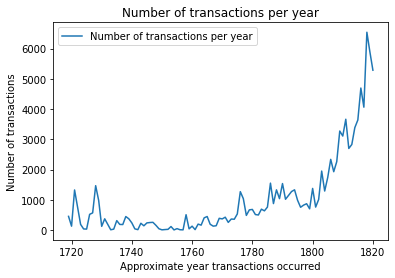

In [131]:
# How many transactions are recorded by year?

total_transactions = num_df['YEAR'].value_counts().sort_index()
plt.plot(total_transactions,label="Number of transactions per year")
plt.title("Number of transactions per year")
plt.ylabel("Number of transactions")
plt.xlabel("Approximate year transactions occurred")
plt.legend()
plt.show()

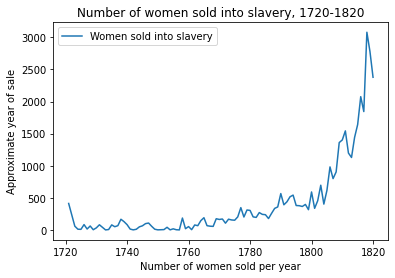

In [132]:
# Plot women sold per year
plt.plot(women_years,label="Women sold into slavery")
plt.title("Number of women sold into slavery, 1720-1820")
plt.xlabel("Number of women sold per year")
plt.ylabel("Approximate year of sale")
plt.legend()
plt.show()

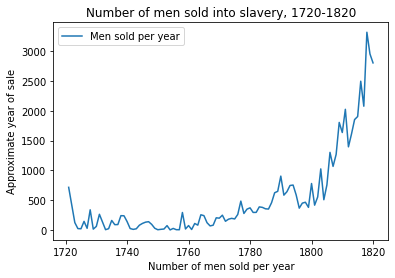

In [133]:
# Plot men sold per year
plt.plot(men_years,label="Men sold per year")
plt.title("Number of men sold into slavery, 1720-1820")
plt.xlabel("Number of men sold per year")
plt.ylabel("Approximate year of sale")
plt.legend()

plt.show()

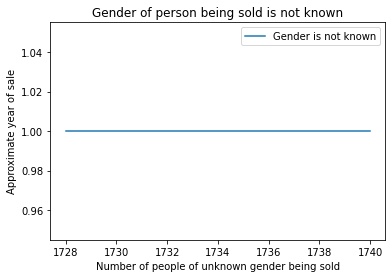

In [134]:
# Plot the unknown gender
plt.plot(num_df['YEAR'].loc[num_df['SEX']<1].value_counts().sort_index(),label="Gender is not known")
plt.title("Gender of person being sold is not known")
plt.xlabel("Number of people of unknown gender being sold")
plt.ylabel("Approximate year of sale")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

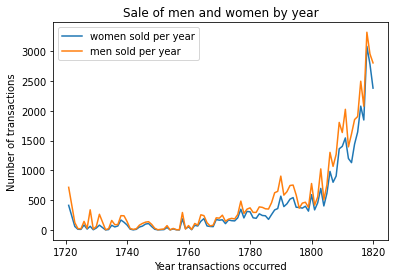

In [135]:
# Plot men and women sold per year
plt.plot(women_years,label='women sold per year')
plt.plot(men_years, label='men sold per year')
plt.title("Sale of men and women by year")
plt.ylabel("Number of transactions")
plt.xlabel("Year transactions occurred")
plt.legend()
plt.show()

In [136]:
emancipation_years = num_df['YEAR'].loc[num_df['EMANCIP']==1].value_counts().sort_index()

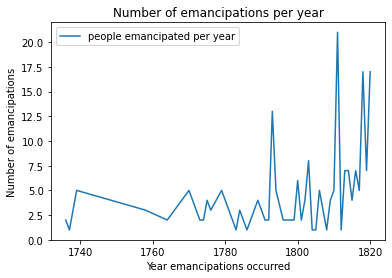

In [137]:
# Plot emancipations per year
plt.plot(emancipation_years,label='people emancipated per year')

plt.title("Number of emancipations per year")
plt.ylabel("Number of emancipations")
plt.xlabel("Year emancipations occurred")
plt.legend()
plt.show()

In [138]:
emancipations_by_age = num_df['AGE'].loc[num_df['EMANCIP']==1] #.value_counts().sort_index()

In [139]:
emancipations_by_age.value_counts().sort_values()

 1.5      1
 48.0     1
 6.0      1
 37.0     1
 0.6      1
 69.0     1
 62.0     1
 65.0     1
 14.5     1
 43.0     1
 76.0     1
 68.0     1
 14.0     1
 5.5      1
 21.0     1
 3.5      1
 85.0     1
 28.5     1
 17.0     1
 2.5      1
 10.0     1
 13.0     2
 8.0      2
 11.0     2
 26.0     2
 7.0      2
 75.0     2
 52.0     2
 24.0     2
 27.0     2
 4.0      3
 12.0     3
 38.0     3
 16.0     3
 50.0     3
 5.0      4
 35.0     4
 9.0      4
 80.0     4
 1.0      4
 15.0     4
 55.0     5
 20.0     5
 3.0      5
 70.0     5
 34.0     5
 45.0     6
 36.0     6
 25.0     6
 22.0     6
 30.0     8
 40.0     8
 28.0     8
 2.0     10
 60.0    12
-1.0     48
Name: AGE, dtype: int64

In [140]:
emancipations_by_age.value_counts().sort_index()

-1.0     48
 0.6      1
 1.0      4
 1.5      1
 2.0     10
 2.5      1
 3.0      5
 3.5      1
 4.0      3
 5.0      4
 5.5      1
 6.0      1
 7.0      2
 8.0      2
 9.0      4
 10.0     1
 11.0     2
 12.0     3
 13.0     2
 14.0     1
 14.5     1
 15.0     4
 16.0     3
 17.0     1
 20.0     5
 21.0     1
 22.0     6
 24.0     2
 25.0     6
 26.0     2
 27.0     2
 28.0     8
 28.5     1
 30.0     8
 34.0     5
 35.0     4
 36.0     6
 37.0     1
 38.0     3
 40.0     8
 43.0     1
 45.0     6
 48.0     1
 50.0     3
 52.0     2
 55.0     5
 60.0    12
 62.0     1
 65.0     1
 68.0     1
 69.0     1
 70.0     5
 75.0     2
 76.0     1
 80.0     4
 85.0     1
Name: AGE, dtype: int64

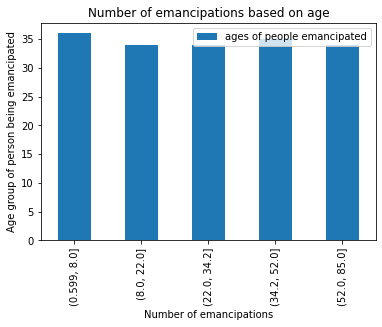

In [141]:
# Plot emancipations by age
emancipations_by_age = emancipations_by_age.loc[emancipations_by_age > 0]


# Divide into 20 bins of roughly 4-5 years age difference
emancipations_by_age_cut = pd.qcut(emancipations_by_age, 5)

emancipations_by_age_cut.value_counts()

emancipations_by_age_cut.value_counts().sort_index().plot(label='ages of people emancipated',kind='bar')
plt.title("Number of emancipations based on age")
plt.xlabel("Number of emancipations")
plt.ylabel("Age group of person being emancipated")
plt.legend()

plt.show()

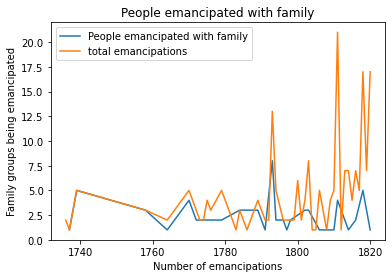

In [142]:
# Plot emancipations by Family_Y_N

emancip_family = num_df['EMANCIP'].loc[num_df['FAMILY_Y_N']==1]
emancip_family = emancip_family[emancip_family == 1]
year_emancip_family = num_df['YEAR'].loc[emancip_family.index].value_counts().sort_index()

plt.plot(year_emancip_family, label='People emancipated with family')
plt.plot(emancipation_years, label='total emancipations')

plt.title("People emancipated with family")
plt.xlabel("Number of emancipations")
plt.ylabel("Family groups being emancipated")
plt.legend()

plt.show()



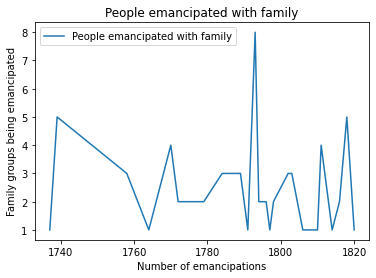

In [143]:
# Plot emancipations by Family_Y_N

emancip_family = num_df['EMANCIP'].loc[num_df['FAMILY_Y_N']==1]
emancip_family = emancip_family[emancip_family == 1]
year_emancip_family = num_df['YEAR'].loc[emancip_family.index].value_counts().sort_index()

plt.plot(year_emancip_family, label='People emancipated with family')


plt.title("People emancipated with family")
plt.xlabel("Number of emancipations")
plt.ylabel("Family groups being emancipated")
plt.legend()

plt.show()


In [144]:
overall = len(emancip_family)

num_df['YEAR'].loc[emancip_family.iloc[range(0,overall)]].value_counts().sort_index()

1719    66
Name: YEAR, dtype: int64

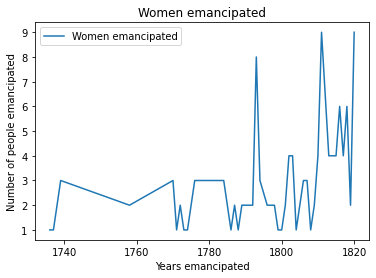

In [145]:
# Plot emancipations by women

emancip_family = num_df['EMANCIP'].loc[num_df['SEX']==1]
emancip_family = emancip_family[emancip_family == 1]
year_emancip_family = num_df['YEAR'].loc[emancip_family.index].value_counts().sort_index()

plt.plot(year_emancip_family, label='Women emancipated')


plt.title("Women emancipated")
plt.xlabel("Years emancipated")
plt.ylabel("Number of people emancipated")
plt.legend()

plt.show()

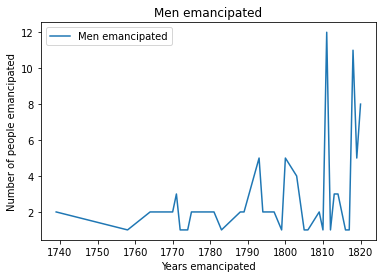

In [146]:
# Plot emancipations by men

emancip_family = num_df['EMANCIP'].loc[num_df['SEX']==2]
emancip_family = emancip_family[emancip_family == 1]
year_emancip_family = num_df['YEAR'].loc[emancip_family.index].value_counts().sort_index()

plt.plot(year_emancip_family, label='Men emancipated')


plt.title("Men emancipated")
plt.xlabel("Years emancipated")
plt.ylabel("Number of people emancipated")
plt.legend()

plt.show()

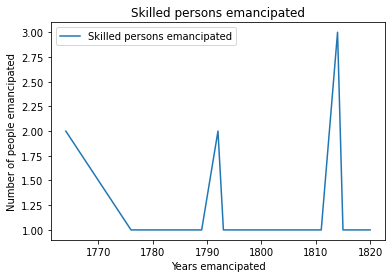

In [147]:
# Plot emancipations by skilled vs unskilled labor

emancip_family = num_df['EMANCIP'].loc[num_df['SKILLCAT']>0]
emancip_family = emancip_family[emancip_family == 1]
skill_emancip_family = num_df['YEAR'].loc[emancip_family.index].value_counts().sort_index()

plt.plot(skill_emancip_family, label='Skilled persons emancipated')


plt.title("Skilled persons emancipated")
plt.xlabel("Years emancipated")
plt.ylabel("Number of people emancipated")
plt.legend()

plt.show()

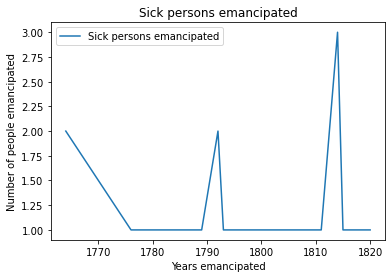

In [148]:
# Plot emancipations by skilled vs unskilled labor

emancip_family = num_df['EMANCIP'].loc[num_df['SICKCAT']>0]
emancip_family = emancip_family[emancip_family == 1]
sick_emancip_family = num_df['YEAR'].loc[emancip_family.index].value_counts().sort_index()

plt.plot(skill_emancip_family, label='Sick persons emancipated')


plt.title("Sick persons emancipated")
plt.xlabel("Years emancipated")
plt.ylabel("Number of people emancipated")
plt.legend()

plt.show()

In [149]:
sick_emancip = num_df['SICKCAT'].loc[num_df['EMANCIP']==1].value_counts()

In [150]:
sick_emancip

-1.0     211
 0.0       2
 74.0      2
 2.0       1
 11.0      1
 14.0      1
 18.0      1
 24.0      1
 90.0      1
Name: SICKCAT, dtype: int64

In [151]:
emancipated = num_df[num_df['EMANCIP']==1]

In [152]:
emancipated_by_freemen = emancipated[emancipated['FREE']==1]

In [153]:
emancipated_by_freemen['SICKCAT'].loc[emancipated_by_freemen['SICKCAT']>0]

9537     74.0
9538     74.0
90226    18.0
Name: SICKCAT, dtype: float64

In [154]:
print(df['NAME'].iloc[9537])
print(df['NAME'].iloc[9538])

Caton
Manon


In [155]:
print(df['SEX'].iloc[9537])
print(df['SEX'].iloc[9538])

2
1


In [156]:
print(df['AGE'].iloc[9537])
print(df['AGE'].iloc[9538])

-1.0
-1.0


In [157]:
print(df['MATE'].iloc[9537])
print(df['MATE'].iloc[9538])

1.0
1.0


In [158]:
print(df['CHILDREN'].iloc[9537])
print(df['CHILDREN'].iloc[9538])

0.0
0.0


In [159]:
print(df['LOCATION'].iloc[9537])
print(df['LOCATION'].iloc[9538])

20.0
20.0


In [160]:
print(df['YEAR'].iloc[9537])
print(df['YEAR'].iloc[9538])

1758
1758


In [161]:
print(df['DEPOT'].iloc[9537])
print(df['SEX'].iloc[9538])

0.0
1


In [162]:
pd.set_option("max_columns", None)
pd.set_option("max_rows",None)
df.iloc[90226]

DOCDATE       1819-02-06 00:00:00
YEAR                         1819
DOCNO                        44.0
NOTARY               Marc Lafitte
CODER                         3.0
DATEINV       1819-02-06 00:00:00
DATESALE      1819-02-06 00:00:00
DEPOT                         0.0
PARISH                         OR
LOCATION                      3.0
DOCTYPE                         7
REVOLTS                      -1.0
MAROON                       -1.0
LANGUAGE                        1
LINGUISTIC                   -1.0
ESTFREE                      -1.0
FREE                          1.0
ESTATE_OF                        
FIRSTNAME                        
ESTATE                           
ESTATEPOP                    -1.0
SELLER           Destrehan (FMOC)
FIRST1                     Honore
BUYER            Destrehan (FWOC)
FIRST2                    Catiche
WENT                         -1.0
NAMEXPLAIN                       
NAME                     Gertrude
NAMETYPE                        7
ISLAMIC       

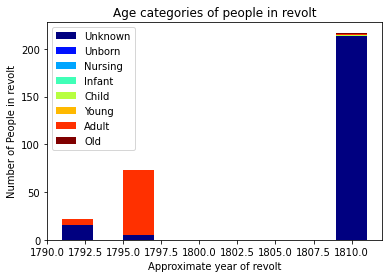

In [163]:
# Stacked histogram showing, for each year, the number of each african language spoken
revolt_clean = num_df[num_df['REVOLTS']>0]
revolt_clean = revolt_clean[['YEAR','AGECATN','AGE']]

jet = plt.cm.jet
colors = jet(np.linspace(0, 1, 8))
rc0 = revolt_clean['YEAR'].loc[revolt_clean['AGECATN']==0]
rc1 = revolt_clean['YEAR'].loc[revolt_clean['AGECATN']==1]
rc2 = revolt_clean['YEAR'].loc[revolt_clean['AGECATN']==2]
rc3 = revolt_clean['YEAR'].loc[revolt_clean['AGECATN']==3]
rc4 = revolt_clean['YEAR'].loc[revolt_clean['AGECATN']==4]
rc5 = revolt_clean['YEAR'].loc[revolt_clean['AGECATN']==5]
rc6 = revolt_clean['YEAR'].loc[revolt_clean['AGECATN']==6]
rc7 = revolt_clean['YEAR'].loc[revolt_clean['AGECATN']==7]

plt.hist([rc0,rc1,rc2,rc3,rc4,rc5,rc6,rc7],color=colors,label=["Unknown","Unborn","Nursing","Infant","Child","Young","Adult","Old"],histtype='barstacked')

plt.title("Age categories of people in revolt")
plt.ylabel("Number of People in revolt")
plt.xlabel("Approximate year of revolt")
plt.legend()
plt.show()

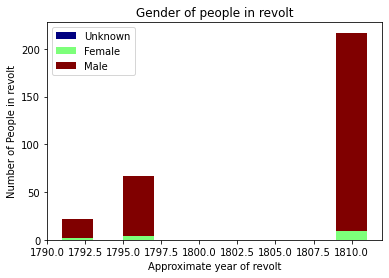

In [164]:

sex_clean = num_df[num_df['REVOLTS']>0]
sex_clean = sex_clean[['YEAR','SEX']]

jet = plt.cm.jet
colors = jet(np.linspace(0, 1, 3))
rc0 = sex_clean['YEAR'].loc[sex_clean['SEX']==0]
rc1 = sex_clean['YEAR'].loc[sex_clean['SEX']==1]
rc2 = sex_clean['YEAR'].loc[sex_clean['SEX']==2]

plt.hist([rc0,rc1,rc2],color=colors,label=["Unknown","Female","Male"],histtype='barstacked')

plt.title("Gender of people in revolt")
plt.ylabel("Number of People in revolt")
plt.xlabel("Approximate year of revolt")
plt.legend()
plt.show()

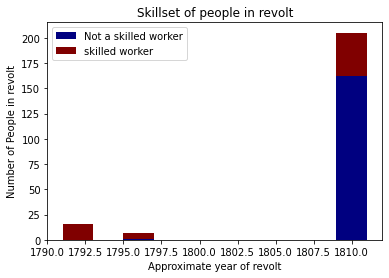

In [165]:
sex_clean = num_df[num_df['REVOLTS']>0]
sex_clean = sex_clean[['YEAR','SKILLCAT']]

jet = plt.cm.jet
colors = jet(np.linspace(0, 1, 2))
rc0 = sex_clean['YEAR'].loc[sex_clean['SKILLCAT']==0]
rc1 = sex_clean['YEAR'].loc[sex_clean['SKILLCAT']>0]


plt.hist([rc0,rc1],color=colors,label=["Not a skilled worker","skilled worker"],histtype='barstacked')

plt.title("Skillset of people in revolt")
plt.ylabel("Number of People in revolt")
plt.xlabel("Approximate year of revolt")
plt.legend()
plt.show()

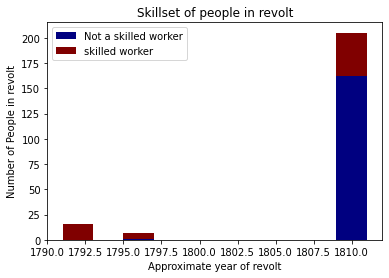

In [166]:
skill_clean = num_df[num_df['REVOLTS']>0]
skill_clean = skill_clean[['YEAR','SKILLCAT']]

jet = plt.cm.jet
colors = jet(np.linspace(0, 1, 2))
rc0 = skill_clean['YEAR'].loc[skill_clean['SKILLCAT']==0]
rc1 = skill_clean['YEAR'].loc[skill_clean['SKILLCAT']>0]


plt.hist([rc0,rc1],color=colors,label=["Not a skilled worker","skilled worker"],histtype='barstacked')

plt.title("Skillset of people in revolt")
plt.ylabel("Number of People in revolt")
plt.xlabel("Approximate year of revolt")
plt.legend()
plt.show()

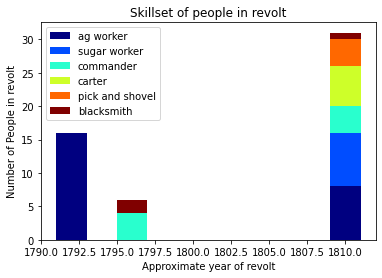

In [167]:
skill_clean = num_df[num_df['REVOLTS']>0]
skill_clean = skill_clean[['YEAR','SKILLCAT']]

jet = plt.cm.jet
colors = jet(np.linspace(0, 1, 6))
rc0 = skill_clean['YEAR'].loc[skill_clean['SKILLCAT']==2]
rc1 = skill_clean['YEAR'].loc[skill_clean['SKILLCAT']==75]
rc2 = skill_clean['YEAR'].loc[skill_clean['SKILLCAT']==1]
rc3 = skill_clean['YEAR'].loc[skill_clean['SKILLCAT']==61]
rc4 = skill_clean['YEAR'].loc[skill_clean['SKILLCAT']==146]
rc5 = skill_clean['YEAR'].loc[skill_clean['SKILLCAT']==110]



plt.hist([rc0,rc1,rc2,rc3,rc4,rc5],color=colors,label=["ag worker","sugar worker","commander","carter","pick and shovel","blacksmith"],histtype='barstacked')

plt.title("Skillset of people in revolt")
plt.ylabel("Number of People in revolt")
plt.xlabel("Approximate year of revolt")
plt.legend()
plt.show()

In [168]:
skill_clean.loc[skill_clean['SKILLCAT'] == 110]

,YEAR,SKILLCAT
33222,1795,110.0
33250,1795,110.0
58267,1811,110.0


In [169]:
df.iloc[58267]

DOCDATE        1811-01-18 00:00:00
YEAR                          1811
DOCNO                         -1.0
NOTARY                            
CODER                          1.0
DATEINV        1811-01-18 00:00:00
DATESALE       1811-01-18 00:00:00
DEPOT                         -1.0
PARISH                            
LOCATION                       6.0
DOCTYPE                         22
REVOLTS                        1.0
MAROON                        -1.0
LANGUAGE                         1
LINGUISTIC                    -1.0
ESTFREE                       -1.0
FREE                          -1.0
ESTATE_OF                         
FIRSTNAME                         
ESTATE                            
ESTATEPOP                     -1.0
SELLER            Kenner&Henderson
FIRST1                            
BUYER                             
FIRST2                            
WENT                          -1.0
NAMEXPLAIN                        
NAME                         Jerry
NAMETYPE            

In [170]:
df.iloc[33250]

DOCDATE                                  1795-05-09 00:00:00
YEAR                                                    1795
DOCNO                                                 1880.0
NOTARY                                         p.55-56,194-5
CODER                                                    3.0
DATEINV                                  1795-05-09 00:00:00
DATESALE                                 1795-05-09 00:00:00
DEPOT                                                    0.0
PARISH                                                    PC
LOCATION                                                15.0
DOCTYPE                                                   24
REVOLTS                                                  1.0
MAROON                                                  -1.0
LANGUAGE                                                   1
LINGUISTIC                                              -1.0
ESTFREE                                                 -1.0
FREE                    

In [171]:
df.iloc[33222]

DOCDATE                 1795-05-09 00:00:00
YEAR                                   1795
DOCNO                                1880.0
NOTARY                                 p.27
CODER                                   3.0
DATEINV                 1795-05-09 00:00:00
DATESALE                1795-05-09 00:00:00
DEPOT                                   0.0
PARISH                                   PC
LOCATION                               15.0
DOCTYPE                                  24
REVOLTS                                 1.0
MAROON                                 -1.0
LANGUAGE                                  1
LINGUISTIC                             -1.0
ESTFREE                                -1.0
FREE                                   -1.0
ESTATE_OF                                  
FIRSTNAME                                  
ESTATE                                     
ESTATEPOP                              -1.0
SELLER                       Lacour (owner)
FIRST1                          

In [172]:
jerry_df = df.loc[df['NAME']=='Jerry']
jerry_df = jerry_df[jerry_df['YEAR'].astype('int') < 1812]
jerry_df = jerry_df[jerry_df['AGE'] > 14]
jerry_df = jerry_df[jerry_df['AGE'] < 31]
jerry_df[['AGE','DOCDATE','SKILLS']]

,AGE,DOCDATE,SKILLS
34248,22.0,1796-08-04,
42930,28.0,1804-07-29,
45834,27.0,1806-05-08,
48568,20.0,1807-09-07,
48672,23.0,1807-10-02,
57038,27.0,1810-09-07,
58267,30.0,1811-01-18,excellent blacksmith
58580,30.0,1811-02-12,
59867,23.0,1811-05-08,


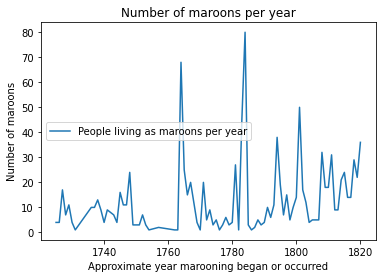

In [173]:
maroon_years = num_df['YEAR'].loc[num_df['MAROON']==1].value_counts().sort_index()
plt.plot(maroon_years,label='People living as maroons per year')

plt.title("Number of maroons per year")
plt.ylabel("Number of maroons")
plt.xlabel("Approximate year marooning began or occurred")
plt.legend()
plt.show()

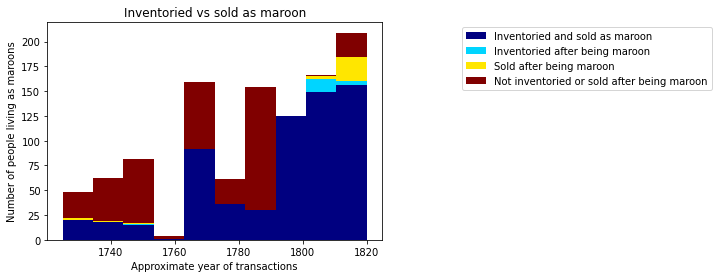

In [174]:
maroon_clean = num_df[num_df['MAROON']==1]
maroon_clean = maroon_clean[['YEAR','INVVALP','SALEVALP']]

mc0 = maroon_clean['YEAR'].loc[maroon_clean['INVVALP']>-1]
mc1 = maroon_clean['YEAR'].loc[maroon_clean['SALEVALP']>-1]
mc2 = maroon_clean['YEAR'].loc[maroon_clean['INVVALP']==-1]
mc3 = mc2.loc[maroon_clean['SALEVALP']==-1]
mc4 = mc0.loc[maroon_clean['SALEVALP']>-1]
mc6 = mc0.loc[maroon_clean['SALEVALP']==-1]
mc7 = mc1.loc[maroon_clean['INVVALP']==-1]

jet = plt.cm.jet
colors = jet(np.linspace(0, 1, 4))

plt.hist([mc4,mc6,mc7,mc3],color=colors,label=["Inventoried and sold as maroon","Inventoried after being maroon","Sold after being maroon","Not inventoried or sold after being maroon"],histtype='barstacked')

plt.title("Inventoried vs sold as maroon")
plt.ylabel("Number of people living as maroons")
plt.xlabel("Approximate year of transactions")
plt.legend(bbox_to_anchor=(2,1))
plt.show()



In [175]:
maroon_clean = num_df[num_df['MAROON']>0]
maroon_clean = maroon_clean[['YEAR','INVVALP','SALEVALP','REVOLTS']]
mc0 = maroon_clean['YEAR'].loc[maroon_clean['REVOLTS']>0]

mc0.value_counts()

1811    27
Name: YEAR, dtype: int64

In [176]:
maroon_clean = num_df[num_df['MAROON']>0]
maroon_doc = maroon_clean[['DOCTYPE']]
maroon_doc.value_counts()


DOCTYPE
7          298
24         260
15         195
1          118
22          85
8           58
18          36
2           12
13           4
14           2
9            1
10           1
dtype: int64

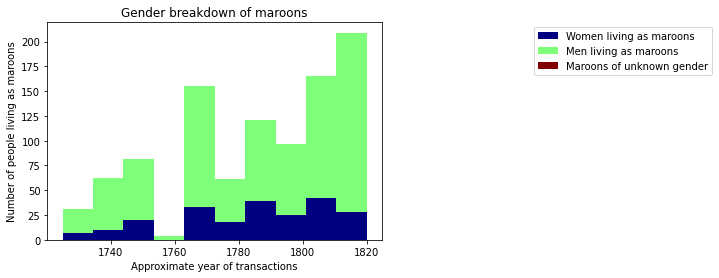

In [177]:
maroon_clean = num_df[num_df['MAROON']==1]
maroon_clean = maroon_clean[['YEAR','SEX']]

women = maroon_clean['YEAR'].loc[maroon_clean['SEX']==1]
men = maroon_clean['YEAR'].loc[maroon_clean['SEX']==2]
unknown = maroon_clean['YEAR'].loc[maroon_clean['SEX']==0]

jet = plt.cm.jet
colors = jet(np.linspace(0, 1, 3))

plt.hist([women, men, unknown],color=colors,label=["Women living as maroons","Men living as maroons","Maroons of unknown gender"],histtype="barstacked")
plt.title("Gender breakdown of maroons")
plt.ylabel("Number of people living as maroons")
plt.xlabel("Approximate year of transactions")
plt.legend(bbox_to_anchor=(2,1))
plt.show()


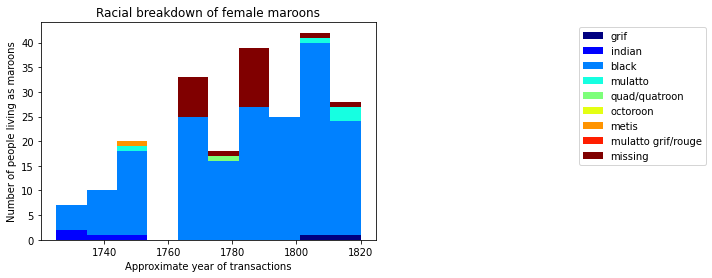

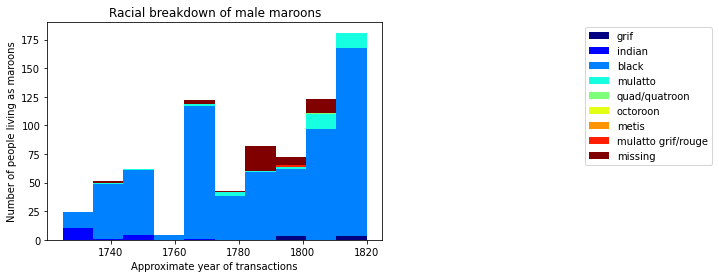

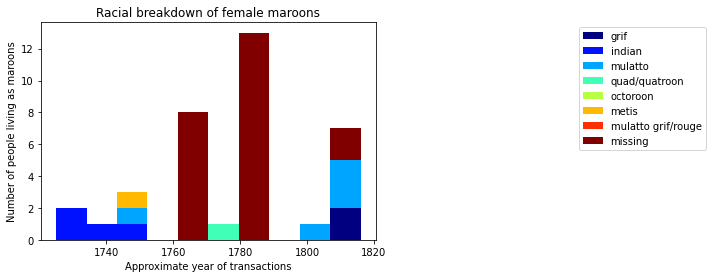

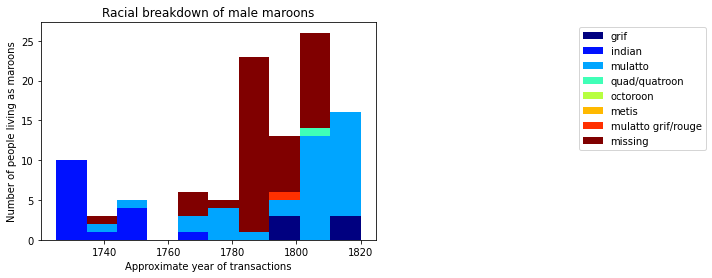

In [178]:


maroon = num_df['MAROON'].loc[num_df['MAROON']==1]
maroon_clean = num_df[['YEAR','SEX','RACE']].loc[maroon.index]
maroon_clean_women = maroon_clean[maroon_clean['SEX']==1]
maroon_clean_men = maroon_clean[maroon_clean['SEX']==2]
gw = maroon_clean_women['YEAR'].loc[maroon_clean_women['RACE']==1]
iw = maroon_clean_women['YEAR'].loc[maroon_clean_women['RACE']==2]
bw = maroon_clean_women['YEAR'].loc[maroon_clean_women['RACE']==3]
mw = maroon_clean_women['YEAR'].loc[maroon_clean_women['RACE']==4]
qw = maroon_clean_women['YEAR'].loc[maroon_clean_women['RACE']==5]
ow = maroon_clean_women['YEAR'].loc[maroon_clean_women['RACE']==6]
mew = maroon_clean_women['YEAR'].loc[maroon_clean_women['RACE']==7]
othw = maroon_clean_women['YEAR'].loc[maroon_clean_women['RACE']==8]
missw = maroon_clean_women['YEAR'].loc[maroon_clean_women['RACE']==9]
gm = maroon_clean_men['YEAR'].loc[maroon_clean_men['RACE']==1]
im = maroon_clean_men['YEAR'].loc[maroon_clean_men['RACE']==2]
bm = maroon_clean_men['YEAR'].loc[maroon_clean_men['RACE']==3]
mm = maroon_clean_men['YEAR'].loc[maroon_clean_men['RACE']==4]
qm = maroon_clean_men['YEAR'].loc[maroon_clean_men['RACE']==5]
om = maroon_clean_men['YEAR'].loc[maroon_clean_men['RACE']==6]
mem = maroon_clean_men['YEAR'].loc[maroon_clean_men['RACE']==7]
othm = maroon_clean_men['YEAR'].loc[maroon_clean_men['RACE']==8]
missm = maroon_clean_men['YEAR'].loc[maroon_clean_men['RACE']==9]
jet = plt.cm.jet
colors = jet(np.linspace(0, 1, 9))

plt.hist([gw,iw,bw,mw,qw,ow,mew,othw,missw], color=colors, label=['grif','indian','black','mulatto','quad/quatroon','octoroon','metis','mulatto grif/rouge','missing'],histtype="barstacked")
plt.title("Racial breakdown of female maroons")
plt.ylabel("Number of people living as maroons")
plt.xlabel("Approximate year of transactions")
plt.legend(bbox_to_anchor=(2,1))
plt.show()
plt.hist([gm,im,bm,mm,qm,om,mem,othm,missm], color=colors, label=['grif','indian','black','mulatto','quad/quatroon','octoroon','metis','mulatto grif/rouge','missing'],histtype="barstacked")

plt.title("Racial breakdown of male maroons")
plt.ylabel("Number of people living as maroons")
plt.xlabel("Approximate year of transactions")
plt.legend(bbox_to_anchor=(2,1))
plt.show()

jet = plt.cm.jet
colors = jet(np.linspace(0, 1, 8))
plt.hist([gw,iw,mw,qw,ow,mew,othw,missw], color=colors, label=['grif','indian','mulatto','quad/quatroon','octoroon','metis','mulatto grif/rouge','missing'],histtype="barstacked")
plt.title("Racial breakdown of female maroons")
plt.ylabel("Number of people living as maroons")
plt.xlabel("Approximate year of transactions")
plt.legend(bbox_to_anchor=(2,1))
plt.show()
plt.hist([gm,im,mm,qm,om,mem,othm,missm], color=colors, label=['grif','indian','mulatto','quad/quatroon','octoroon','metis','mulatto grif/rouge','missing'],histtype="barstacked")

plt.title("Racial breakdown of male maroons")
plt.ylabel("Number of people living as maroons")
plt.xlabel("Approximate year of transactions")
plt.legend(bbox_to_anchor=(2,1))
plt.show()


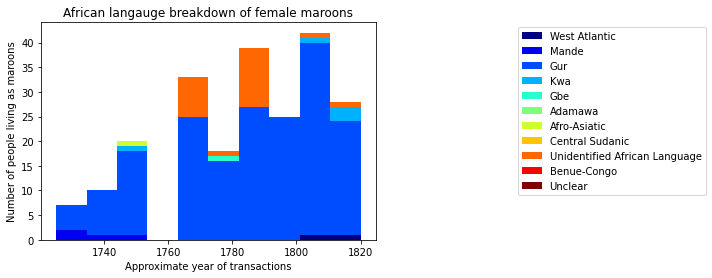

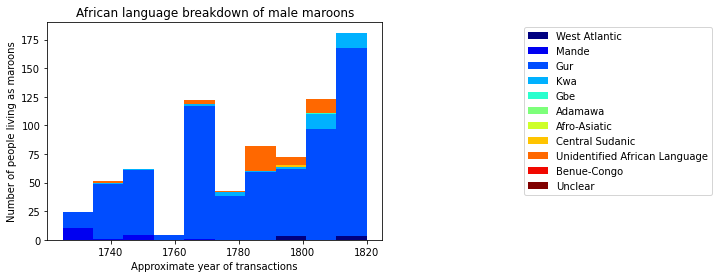

In [179]:


maroon_aflang = num_df['MAROON'].loc[num_df['MAROON']==1]
maroon_aflang = num_df[['YEAR','SEX','RACE']].loc[maroon.index]
maroon_aflang_women = maroon_aflang[maroon_clean['SEX']==1]
maroon_aflang_men = maroon_aflang[maroon_clean['SEX']==2]
gw = maroon_aflang_women['YEAR'].loc[maroon_aflang_women['RACE']==1]
iw = maroon_aflang_women['YEAR'].loc[maroon_aflang_women['RACE']==2]
bw = maroon_aflang_women['YEAR'].loc[maroon_aflang_women['RACE']==3]
mw = maroon_aflang_women['YEAR'].loc[maroon_aflang_women['RACE']==4]
qw = maroon_aflang_women['YEAR'].loc[maroon_aflang_women['RACE']==5]
ow = maroon_aflang_women['YEAR'].loc[maroon_aflang_women['RACE']==6]
mew = maroon_aflang_women['YEAR'].loc[maroon_aflang_women['RACE']==7]
othw = maroon_aflang_women['YEAR'].loc[maroon_aflang_women['RACE']==8]
missw = maroon_aflang_women['YEAR'].loc[maroon_aflang_women['RACE']==9]
twelvew = maroon_aflang_women['YEAR'].loc[maroon_aflang_women['RACE']==12]
fourteenw = maroon_aflang_women['YEAR'].loc[maroon_aflang_women['RACE']==14]
gm = maroon_aflang_men['YEAR'].loc[maroon_aflang_men['RACE']==1]
im = maroon_aflang_men['YEAR'].loc[maroon_aflang_men['RACE']==2]
bm = maroon_aflang_men['YEAR'].loc[maroon_aflang_men['RACE']==3]
mm = maroon_aflang_men['YEAR'].loc[maroon_aflang_men['RACE']==4]
qm = maroon_aflang_men['YEAR'].loc[maroon_aflang_men['RACE']==5]
om = maroon_aflang_men['YEAR'].loc[maroon_aflang_men['RACE']==6]
mem = maroon_aflang_men['YEAR'].loc[maroon_aflang_men['RACE']==7]
othm = maroon_aflang_men['YEAR'].loc[maroon_aflang_men['RACE']==8]
missm = maroon_aflang_men['YEAR'].loc[maroon_aflang_men['RACE']==9]
twelvem = maroon_aflang_men['YEAR'].loc[maroon_aflang_men['RACE']==12]
fourteenm = maroon_aflang_men['YEAR'].loc[maroon_aflang_men['RACE']==14]
jet = plt.cm.jet
colors = jet(np.linspace(0, 1, 11))
languages = ['West Atlantic','Mande','Gur','Kwa','Gbe','Adamawa','Afro-Asiatic','Central Sudanic','Unidentified African Language','Benue-Congo','Unclear']
plt.hist([gw,iw,bw,mw,qw,ow,mew,othw,missw,twelvew,fourteenw], color=colors, label=languages,histtype='barstacked')
plt.title("African langauge breakdown of female maroons")
plt.ylabel("Number of people living as maroons")
plt.xlabel("Approximate year of transactions")
plt.legend(bbox_to_anchor=(2,1))
plt.show()
plt.hist([gm,im,bm,mm,qm,om,mem,othm,missm,twelvem,fourteenm], color=colors, label=languages,histtype='barstacked')
plt.title("African language breakdown of male maroons")
plt.ylabel("Number of people living as maroons")
plt.xlabel("Approximate year of transactions")
plt.legend(bbox_to_anchor=(2,1))
plt.show()



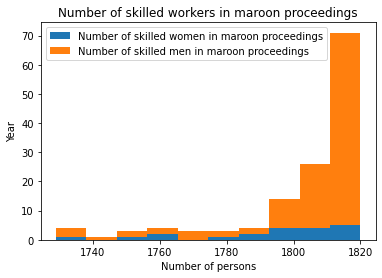

In [180]:
maroon = num_df['MAROON'].loc[num_df['MAROON']==1]
maroon_skills = num_df[['YEAR','SEX','SKILLCAT']].loc[maroon.index]
maroon_skills = maroon_skills[maroon_skills['SKILLCAT']>0]
maroon_skills_women = maroon_skills[maroon_skills['SEX']==1]
maroon_skills_men = maroon_skills[maroon_skills['SEX']==2]
maroon_skills_women = maroon_skills_women[['YEAR','SKILLCAT']]

plt.hist([maroon_skills_women['YEAR'].loc[maroon_skills_women['SKILLCAT']>0],maroon_skills_men['YEAR'].loc[maroon_skills_men['SKILLCAT']>0]],label=["Number of skilled women in maroon proceedings","Number of skilled men in maroon proceedings"],histtype='barstacked')
plt.title("Number of skilled workers in maroon proceedings")
plt.xlabel("Number of persons")
plt.ylabel("Year")
plt.legend()
plt.show()

In [184]:
maroon = num_df['MAROON'].loc[num_df['MAROON']==1]
maroon_skills = num_df.loc[maroon.index]
df.loc[maroon_skills[maroon_skills['YEAR']==1811].loc[maroon_skills['SKILLCAT']==61].index]

,DOCDATE,YEAR,DOCNO,NOTARY,CODER,DATEINV,DATESALE,DEPOT,PARISH,LOCATION,DOCTYPE,REVOLTS,MAROON,LANGUAGE,LINGUISTIC,ESTFREE,FREE,ESTATE_OF,FIRSTNAME,ESTATE,ESTATEPOP,SELLER,FIRST1,BUYER,FIRST2,WENT,NAMEXPLAIN,NAME,NAMETYPE,ISLAMIC,SEX,RACE,AGE,AGECATN,SKILLS,SKILLCAT,EXPERT,APPRENTICE,ALITTLE,SKILL2,SKILL3,SKILL4,SKILL5,CHARACTER,CHARCAT,CHARCAT2,CHARCAT3,SICK,SICKCAT,SICK2,SICK3,SICK4,SPELL,BIRTHPL,AFLANG,BRUT,GROUP,GROUPMEMB,INVCUR,INVVALUE,INVVALP,SALECUR,SALEVALUE,SALEVALP,FAMILY_Y_N,FAMILY,CHILDREN,MALE,FEMALE,UNDER5,PREGNANT,MOTHER,AGEMOM,RACEMOM,INVWMOM,SOLDWMOM,SPNATMOM,ORMOM,MATE,MATENAME,AGEMATE,AGECATMATE,RACEMATE,SPELNAMATE,ORIGINMATE,FATHER,AGEDAD,RACEDAD,SPNADAD,ORDAD,GRANDCHILD,GRANDSONS,GDAUGHTERS,GRANDMA,AGEGRANDMA,SPNAGM,ORGRANDMA,GRANPA,AGEGRANDPA,SPNAGRPA,ORGRANDPA,EMANCIP,DEAD,RUNAWAY,ENTERPRISE,CAPTAIN,SLAVETRADE,STPORT,SHIP,ARRIVEDATE,FROM,UNBAPT,VIA
58235,1811-01-18,1811,-1.0,,1.0,1811-01-18,1811-01-18,-1.0,,6.0,22,1.0,1.0,1,-1.0,-1.0,-1.0,,,,-1.0,Fortier,Adelard,,,-1.0,,Sam,8,UNKNOWN,2,3.0,25.0,-1.0,carter,61.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,,-1.0,-1.0,-1.0,,-1.0,-1.0,-1.0,-1.0,,0.0,-1.0,-1.0,2.0,,d,700.0,700.0,,-1.0,-1.0,-1.0,,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,,-1.0,-1.0,,-1.0,-1.0,-1.0,,-1.0,-1.0,-1.0,0.0,,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,,-1.0,-1.0,-1.0,,-1.0,-1.0,1.0,-1.0,-1.0,,UNKNOWN,-1.0,,1811-01-18,,UNKNOWN,-1.0
58263,1811-01-18,1811,-1.0,,1.0,1811-01-18,1811-01-18,-1.0,,6.0,22,1.0,1.0,1,-1.0,-1.0,-1.0,,,,-1.0,Kenner&Henderson,,,,-1.0,,Charles,7,UNKNOWN,2,3.0,25.0,-1.0,"good carter, laborer",61.0,1.0,-1.0,-1.0,2.0,-1.0,-1.0,0.0,,-1.0,-1.0,-1.0,,-1.0,-1.0,-1.0,-1.0,,0.0,-1.0,-1.0,2.0,,d,1000.0,1000.0,,-1.0,-1.0,-1.0,,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,,-1.0,-1.0,,-1.0,-1.0,-1.0,,-1.0,-1.0,-1.0,0.0,,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,,-1.0,-1.0,-1.0,,-1.0,-1.0,-1.0,1.0,-1.0,,UNKNOWN,-1.0,,1811-01-18,,UNKNOWN,-1.0


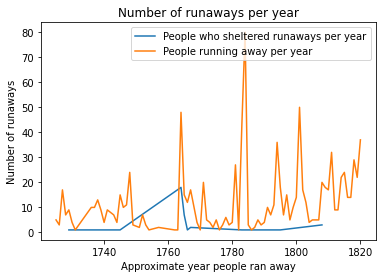

In [197]:
runaway_years = num_df['YEAR'].loc[num_df['RUNAWAY']==1].value_counts().sort_index()
sheltering_years = num_df['YEAR'].loc[num_df['RUNAWAY']==2].value_counts().sort_index()
runaway_not_maroon = num_df['YEAR'].loc[num_df['RUNAWAY'] == 1].loc[num_df['MAROON']!=1].value_counts().sort_index()

plt.plot(sheltering_years, label="People who sheltered runaways per year")
plt.plot(runaway_years,label='People running away per year')

plt.title("Number of runaways per year")
plt.ylabel("Number of runaways")
plt.xlabel("Approximate year people ran away")
plt.legend()
plt.show()

In [198]:
runaway_not_maroon

1725    1
1792    1
1811    2
1814    1
1820    1
Name: YEAR, dtype: int64

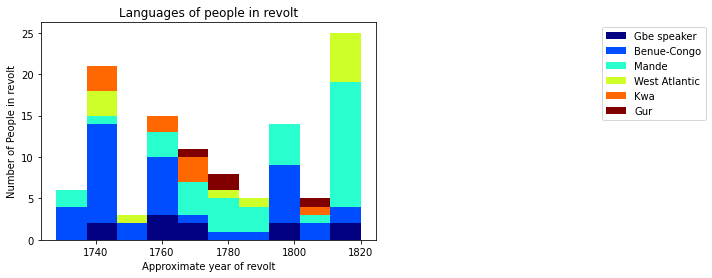

In [179]:
lang_clean = num_df[num_df['MAROON']>0]
lang_clean = lang_clean[['YEAR','AFLANG']]

jet = plt.cm.jet
colors = jet(np.linspace(0, 1, 6))
rc0 = lang_clean['YEAR'].loc[lang_clean['AFLANG']==0]
rc1 = lang_clean['YEAR'].loc[lang_clean['AFLANG']==5]
rc2 = lang_clean['YEAR'].loc[lang_clean['AFLANG']==2]
rc3 = lang_clean['YEAR'].loc[lang_clean['AFLANG']==12]
rc4 = lang_clean['YEAR'].loc[lang_clean['AFLANG']==1]
rc5 = lang_clean['YEAR'].loc[lang_clean['AFLANG']==4]
rc6 = lang_clean['YEAR'].loc[lang_clean['AFLANG']==3]


plt.hist([rc1,rc2,rc3,rc4,rc5,rc6],color=colors,label=["Gbe speaker","Benue-Congo","Mande","West Atlantic","Kwa","Gur"],histtype='barstacked')

plt.title("Languages of people in revolt")
plt.ylabel("Number of People in revolt")
plt.xlabel("Approximate year of revolt")
plt.legend(bbox_to_anchor=(2,1))
plt.show()

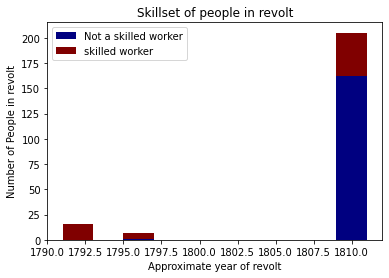

In [175]:
skill_clean = num_df[num_df['REVOLTS']>0]
skill_clean = sex_clean[['YEAR','SKILLCAT']]

jet = plt.cm.jet
colors = jet(np.linspace(0, 1, 2))
rc0 = skill_clean['YEAR'].loc[skill_clean['SKILLCAT']==0]
rc1 = skill_clean['YEAR'].loc[skill_clean['SKILLCAT']>0]


plt.hist([rc0,rc1],color=colors,label=["Not a skilled worker","skilled worker"],histtype='barstacked')

plt.title("Skillset of people in revolt")
plt.ylabel("Number of People in revolt")
plt.xlabel("Approximate year of revolt")
plt.legend()
plt.show()

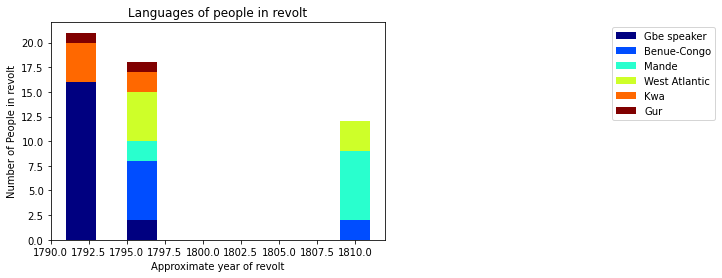

In [176]:
lang_clean = num_df[num_df['REVOLTS']>0]
lang_clean = lang_clean[['YEAR','AFLANG']]

jet = plt.cm.jet
colors = jet(np.linspace(0, 1, 6))
rc0 = lang_clean['YEAR'].loc[lang_clean['AFLANG']==0]
rc1 = lang_clean['YEAR'].loc[lang_clean['AFLANG']==5]
rc2 = lang_clean['YEAR'].loc[lang_clean['AFLANG']==2]
rc3 = lang_clean['YEAR'].loc[lang_clean['AFLANG']==12]
rc4 = lang_clean['YEAR'].loc[lang_clean['AFLANG']==1]
rc5 = lang_clean['YEAR'].loc[lang_clean['AFLANG']==4]
rc6 = lang_clean['YEAR'].loc[lang_clean['AFLANG']==3]


plt.hist([rc1,rc2,rc3,rc4,rc5,rc6],color=colors,label=["Gbe speaker","Benue-Congo","Mande","West Atlantic","Kwa","Gur"],histtype='barstacked')

plt.title("Languages of people in revolt")
plt.ylabel("Number of People in revolt")
plt.xlabel("Approximate year of revolt")
plt.legend(bbox_to_anchor=(2,1))
plt.show()


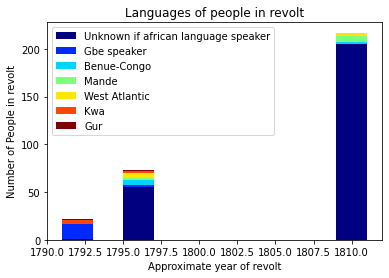

In [177]:
lang_clean = num_df[num_df['REVOLTS']>0]
lang_clean = lang_clean[['YEAR','AFLANG']]

jet = plt.cm.jet
colors = jet(np.linspace(0, 1, 7))
rc0 = lang_clean['YEAR'].loc[lang_clean['AFLANG']==0]
rc1 = lang_clean['YEAR'].loc[lang_clean['AFLANG']==5]
rc2 = lang_clean['YEAR'].loc[lang_clean['AFLANG']==2]
rc3 = lang_clean['YEAR'].loc[lang_clean['AFLANG']==12]
rc4 = lang_clean['YEAR'].loc[lang_clean['AFLANG']==1]
rc5 = lang_clean['YEAR'].loc[lang_clean['AFLANG']==4]
rc6 = lang_clean['YEAR'].loc[lang_clean['AFLANG']==3]


plt.hist([rc0,rc1,rc2,rc3,rc4,rc5,rc6],color=colors,label=["Unknown if african language speaker","Gbe speaker","Benue-Congo","Mande","West Atlantic","Kwa","Gur"],histtype='barstacked')

plt.title("Languages of people in revolt")
plt.ylabel("Number of People in revolt")
plt.xlabel("Approximate year of revolt")
plt.legend()
plt.show()

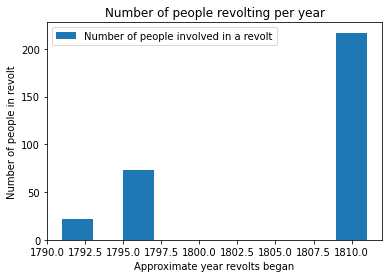

In [162]:
revolt_years = num_df['YEAR'].loc[num_df['REVOLTS']==1]

plt.hist(revolt_years,label="Number of people involved in a revolt")

plt.title("Number of people revolting per year")
plt.ylabel("Number of people in revolt")
plt.xlabel("Approximate year revolts began")
plt.legend()
plt.show()

In [211]:
muslims = df[df["ISLAMIC"] == '1.

3850      1.0
6116      1.0
6174      1.0
6175      1.0
6195      1.0
6423      1.0
6433      1.0
6449      1.0
6581      1.0
6587      1.0
6610      1.0
6649      1.0
6650      1.0
6728      1.0
6729      1.0
6806      1.0
6914      1.0
6925      1.0
7054      1.0
7139      1.0
7215      1.0
7302      1.0
7343      1.0
7354      1.0
7376      1.0
7598      1.0
7614      1.0
7656      1.0
7867      1.0
7887      1.0
7972      1.0
8280      1.0
8578      1.0
8579      1.0
8701      1.0
8857      1.0
8938      1.0
8947      1.0
9006      1.0
9029      1.0
9037      1.0
9098      1.0
9100      1.0
9107      1.0
9128      1.0
9216      1.0
9773      1.0
9780      1.0
10028     1.0
10066     1.0
10091     1.0
10105     1.0
10126     1.0
10222     1.0
10238     1.0
10486     1.0
10538     1.0
10568     1.0
10825     1.0
10862     1.0
11031     1.0
11200     1.0
11275     1.0
11630     1.0
12067     1.0
12124     1.0
12127     1.0
12337     1.0
12644     1.0
13047     1.0
13133     1.0
13258 

In [163]:
revolt_years.value_counts()

1811    217
1795     73
1791     22
Name: YEAR, dtype: int64

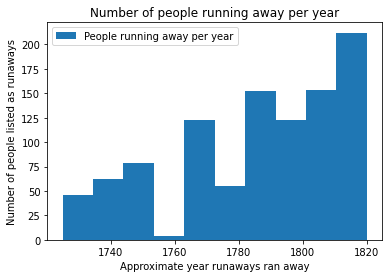

In [164]:
# Runaways per year is best modeled as a histogram
run_years = num_df['YEAR'].loc[num_df['RUNAWAY']==1]
plt.hist(run_years,label='People running away per year')

plt.title("Number of people running away per year")
plt.ylabel("Number of people listed as runaways")
plt.xlabel("Approximate year runaways ran away")
plt.legend()
plt.show()

In [165]:
run_years

2131      1725
2147      1725
2148      1725
2151      1725
2152      1725
          ... 
99660     1820
100029    1820
100322    1820
100422    1820
100554    1820
Name: YEAR, Length: 1009, dtype: int32

Took me so long to figure out that I could just use groupby. I decided to do the average transaction because total transactions was huge, 60000 records, and couldn't easily be plotted.

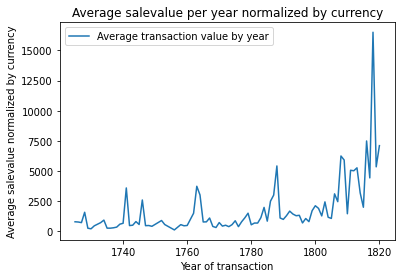

In [166]:
# Salevalp per year per transaction
salevalp = num_df['SALEVALP'].loc[num_df['SALEVALP']>0].groupby(num_df['YEAR']).mean()
plt.plot(salevalp,label="Average transaction value by year")
plt.title("Average salevalue per year normalized by currency")
plt.ylabel("Average salevalue normalized by currency")
plt.xlabel("Year of transaction")
plt.legend()
plt.show()



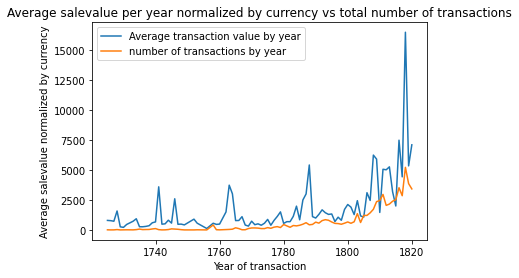

In [167]:
# Salevalp per year per transaction plotted against total number of transactions
salevalp = num_df['SALEVALP'].loc[num_df['SALEVALP']>0].groupby(num_df['YEAR']).mean()
num_transactions = num_df['YEAR'].loc[num_df['SALEVALP']>0].value_counts().sort_index()
plt.plot(salevalp,label="Average transaction value by year")
plt.plot(num_transactions,label="number of transactions by year")
plt.title("Average salevalue per year normalized by currency vs total number of transactions")
plt.ylabel("Average salevalue normalized by currency")
plt.xlabel("Year of transaction")
plt.legend()
plt.show()

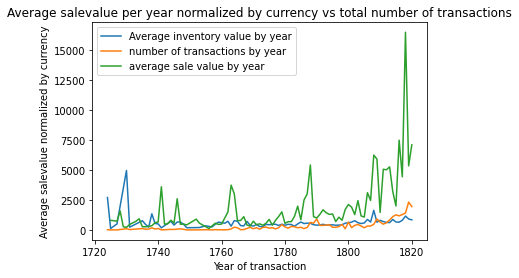

In [168]:
# Inventory value plotted against number of transactions a year
# Notice that inventory value was high when few inventories were being made
invvalp = num_df['INVVALP'].loc[num_df['INVVALP']>0].groupby(num_df['YEAR']).mean()
num_transactions = num_df['YEAR'].loc[num_df['INVVALP']>0].value_counts().sort_index()
plt.plot(invvalp,label="Average inventory value by year")
plt.plot(num_transactions,label="number of transactions by year")
plt.plot(salevalp,label="average sale value by year")
plt.title("Average salevalue per year normalized by currency vs total number of transactions")
plt.ylabel("Average salevalue normalized by currency")
plt.xlabel("Year of transaction")
plt.legend()
plt.show()

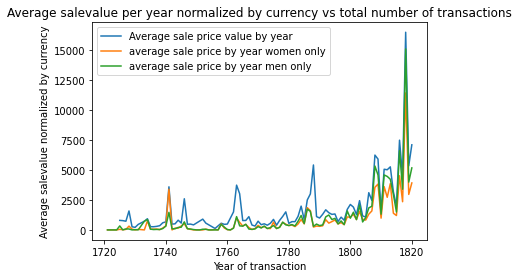

In [169]:
# Sale value in general, men and women plotted against each other

salevalp = num_df['SALEVALP'].loc[num_df['SALEVALP']>0].groupby(num_df['YEAR']).mean()
salevalp_women = num_df['SALEVALP'].loc[(num_df['SEX']==1)].groupby(num_df['YEAR']).mean()
salevalp_men = num_df['SALEVALP'].loc[(num_df['SEX']==2)].groupby(num_df['YEAR']).mean()
plt.plot(salevalp,label="Average sale price value by year")

plt.plot(salevalp_women,label="average sale price by year women only")
plt.plot(salevalp_men,label="average sale price by year men only")
plt.title("Average salevalue per year normalized by currency vs total number of transactions")
plt.ylabel("Average salevalue normalized by currency")
plt.xlabel("Year of transaction")
plt.legend()
plt.show()

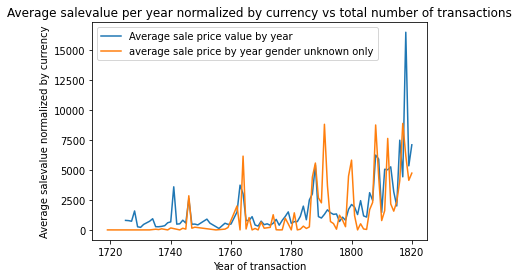

In [170]:
# Sale value in general, plotted against those cases where gender is unknown
num_df['SEX'] = num_df['SEX'].replace([-1,9],0)

salevalp = num_df['SALEVALP'].loc[num_df['SALEVALP']>0].groupby(num_df['YEAR']).mean()
salevalp_unknown_gender = num_df['SALEVALP'].loc[(num_df['SEX'] == 0)].groupby(num_df['YEAR']).mean()
plt.plot(salevalp,label="Average sale price value by year")

plt.plot(salevalp_unknown_gender,label="average sale price by year gender unknown only")

plt.title("Average salevalue per year normalized by currency vs total number of transactions")
plt.ylabel("Average salevalue normalized by currency")
plt.xlabel("Year of transaction")
plt.legend()
plt.show()

I'm getting more and more curious about these mysterious unknown gender actors. Why do they have independent valuations outside the general trend lines, when men and women followed roughly the same trends? Unfortunately, this happens.

In [171]:
num_df[num_df[num_df['SEX'] == 0] > 0]

,ORDAD,LINGUISTIC,SICKCAT,INVVALUE,CHARCAT2,MOTHER,RUNAWAY,MATE,DOCTYPE,SKILLCAT,...,CHARCAT,AGECATN,AFLANG,SALEVALUE,FREE,SOLDWMOM,DEPOT,RACEMOM,BIRTHPL,FEMALE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,55.0,NaN,498.0,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,55.0,NaN,498.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,55.0,NaN,498.0,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,55.0,NaN,498.0,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,55.0,NaN,498.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It's a super sparse graph, that unfortunately has some values. Basically, it just shows the issue with historical documents. The information is incomplete.

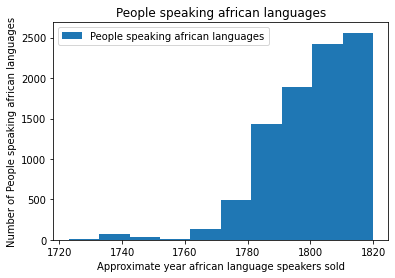

In [172]:
# Persons known to speak african languages by year
aflang = num_df['YEAR'].loc[num_df['AFLANG']>0]
plt.hist(aflang,label='People speaking african languages')

plt.title("People speaking african languages")
plt.ylabel("Number of People speaking african languages")
plt.xlabel("Approximate year african language speakers sold")
plt.legend()
plt.show()


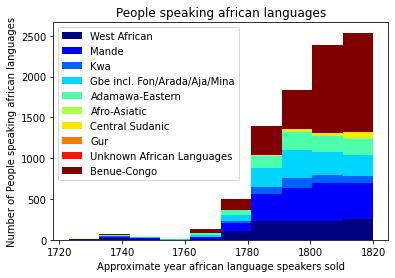

In [173]:
# Stacked histogram showing, for each year, the number of each african language spoken
aflang_clean = num_df[num_df['AFLANG']>0]
aflang_clean = aflang_clean[['YEAR','AFLANG']]

jet = plt.cm.jet
colors = jet(np.linspace(0, 1, 10))
afc1 = aflang_clean['YEAR'].loc[aflang_clean['AFLANG']==1]
afc2 = aflang_clean['YEAR'].loc[aflang_clean['AFLANG']==2]
afc4 = aflang_clean['YEAR'].loc[aflang_clean['AFLANG']==4]
afc5 = aflang_clean['YEAR'].loc[aflang_clean['AFLANG']==5]
afc6 = aflang_clean['YEAR'].loc[aflang_clean['AFLANG']==6]
afc7 = aflang_clean['YEAR'].loc[aflang_clean['AFLANG']==7]
afc8 = aflang_clean['YEAR'].loc[aflang_clean['AFLANG']==8]
afc3 = aflang_clean['YEAR'].loc[aflang_clean['AFLANG']==3]
afc9 = aflang_clean['YEAR'].loc[aflang_clean['AFLANG']==9]
afc12 = aflang_clean['YEAR'].loc[aflang_clean['AFLANG']==12]
plt.hist([afc1,afc2,afc3,afc4,afc5,afc6,afc7,afc8,afc9,afc12],color=colors,label=["West African","Mande","Kwa","Gbe incl. Fon/Arada/Aja/Mina","Adamawa-Eastern","Afro-Asiatic","Central Sudanic","Gur","Unknown African Languages","Benue-Congo"],histtype='barstacked')

plt.title("People speaking african languages")
plt.ylabel("Number of People speaking african languages")
plt.xlabel("Approximate year african language speakers sold")
plt.legend()
plt.show()

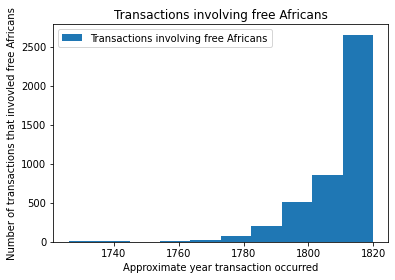

In [174]:
# Transactions involving freed Africans, i.e. indirectly showing the status
# of free Africans.
free_af = num_df['YEAR'].loc[num_df['FREE']==1]
plt.hist(free_af,label='Transactions involving free Africans')

plt.title("Transactions involving free Africans")
plt.ylabel("Number of transactions that invovled free Africans")
plt.xlabel("Approximate year transaction occurred")
plt.legend()
plt.show()

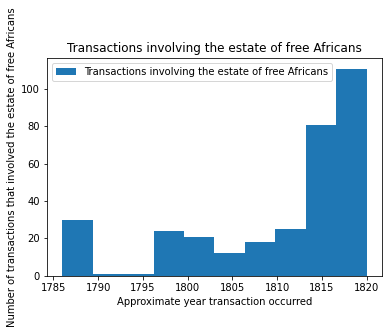

In [175]:
# Transactions that involve the estate of a free African.
estate_free = num_df['YEAR'].loc[num_df['ESTFREE']==1]
plt.hist(estate_free,label='Transactions involving the estate of free Africans')

plt.title("Transactions involving the estate of free Africans")
plt.ylabel("Number of transactions that involved the estate of free Africans")
plt.xlabel("Approximate year transaction occurred")
plt.legend()
plt.show()

This is maybe not what I expected. However, what is this compared to the total volume of transactions?

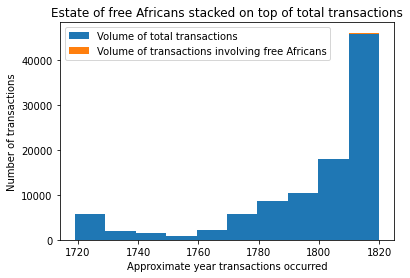

In [176]:
# Stacked histogram showing the number of estate transactions vs the number of estate transactions of free Africans
plt.subplots()
total_transactions = num_df['YEAR']
plt.hist([total_transactions,estate_free],label=["Volume of total transactions","Volume of transactions involving free Africans"], histtype='barstacked')

plt.title("Estate of free Africans stacked on top of total transactions")
plt.ylabel("Number of transactions")
plt.xlabel("Approximate year transactions occurred")
plt.legend()
plt.show()

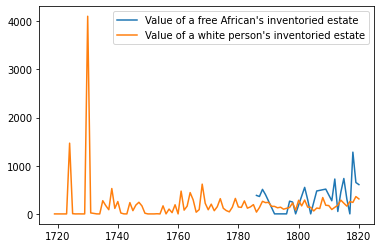

In [177]:
# Can we tell the salevalue of a free African's estate? Is it going up or down?
estate_free_value = num_df['INVVALP'].loc[num_df['ESTFREE']>0].groupby(num_df['YEAR']).mean()
estate_white_value = num_df['INVVALP'].loc[num_df['ESTFREE']<1].groupby(num_df['YEAR']).mean()
plt.plot(estate_free_value,label="Value of a free African's inventoried estate")
plt.plot(estate_white_value,label="Value of a white person's inventoried estate")
plt.legend()

plt.show()

What the hell? Why is the inventoried value of African estates slightly higher than the average white estate? What if we modeled it against the sale value?

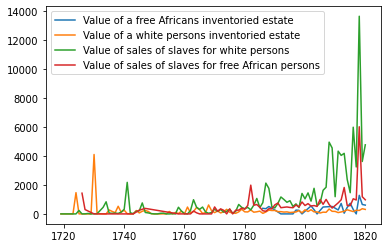

In [178]:
# Can we tell the salevalue of a free African's estate? Is it going up or down?
estate_free_value = num_df['INVVALP'].loc[num_df['ESTFREE']>0].groupby(num_df['YEAR']).mean()
estate_white_value = num_df['INVVALP'].loc[num_df['ESTFREE']<1].groupby(num_df['YEAR']).mean()
white_sale_value = num_df['SALEVALP'].loc[num_df['FREE']<1].groupby(num_df['YEAR']).mean()
free_sale_value = num_df['SALEVALP'].loc[num_df['FREE']==1].groupby(num_df['YEAR']).mean()
plt.plot(estate_free_value,label="Value of a free Africans inventoried estate")
plt.plot(estate_white_value,label="Value of a white persons inventoried estate")
plt.plot(white_sale_value, label="Value of sales of slaves for white persons")  
plt.plot(free_sale_value,label="Value of sales of slaves for free African persons")
plt.legend()

plt.show()

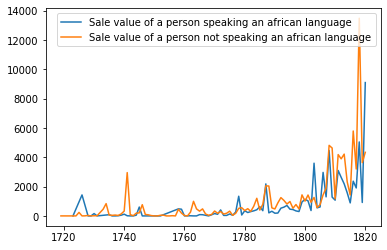

In [179]:
# What is the sale value of a person speaking an African language?
aflang_value = num_df['SALEVALP'].loc[num_df['AFLANG']>0].groupby(num_df['YEAR']).mean()
not_aflang_value = num_df['SALEVALP'].loc[num_df['AFLANG']<=0].groupby(num_df['YEAR']).mean()
plt.plot(aflang_value,label="Sale value of a person speaking an african language")
plt.plot(not_aflang_value,label="Sale value of a person not speaking an african language")
plt.legend()
plt.show()

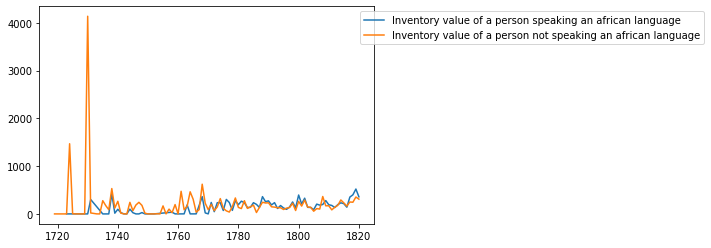

In [180]:
# Inventory value of an Africanlanguage speaker vs not
aflang_value = num_df['INVVALP'].loc[num_df['AFLANG']>0].groupby(num_df['YEAR']).mean()
not_aflang_value = num_df['INVVALP'].loc[num_df['AFLANG']<=0].groupby(num_df['YEAR']).mean()
plt.plot(aflang_value,label="Inventory value of a person speaking an african language")
plt.plot(not_aflang_value,label="Inventory value of a person not speaking an african language")
plt.legend(bbox_to_anchor=(2,1))
plt.show()

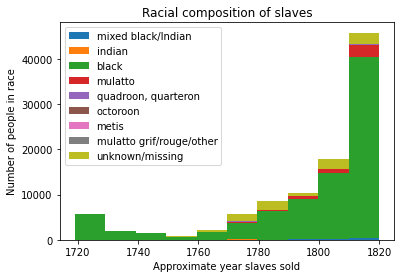

In [181]:
# Stacked histogram showing, for each year, the race of those sold at auction
race = num_df[num_df['RACE']>0]
race = race[['YEAR','RACE']]
plt.subplots()
r1 = race['YEAR'].loc[race['RACE']==1]
r2 = race['YEAR'].loc[race['RACE']==2]
r4 = race['YEAR'].loc[race['RACE']==4]
r5 = race['YEAR'].loc[race['RACE']==5]
r6 = race['YEAR'].loc[race['RACE']==6]
r7 = race['YEAR'].loc[race['RACE']==7]
r8 = race['YEAR'].loc[race['RACE']==8]
r3 = race['YEAR'].loc[race['RACE']==3]
r9 = race['YEAR'].loc[race['RACE']==9]

plt.hist([r1,r2,r3,r4,r5,r6,r7,r8,r9],10,label=["mixed black/Indian","indian","black","mulatto","quadroon, quarteron","octoroon","metis","mulatto grif/rouge/other","unknown/missing"],histtype='barstacked')

plt.title("Racial composition of slaves")
plt.ylabel("Number of people in race")
plt.xlabel("Approximate year slaves sold")
plt.legend()
plt.show()

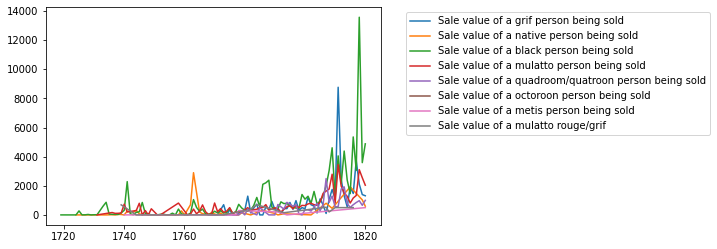

In [182]:
# Does the race of a person being sold change their value?
grif_value = num_df['SALEVALP'].loc[num_df['RACE']==1].groupby(num_df['YEAR']).mean()
native_value = num_df['SALEVALP'].loc[num_df['RACE']==2].groupby(num_df['YEAR']).mean()
black_value = num_df['SALEVALP'].loc[num_df['RACE']==3].groupby(num_df['YEAR']).mean()
mulatto_value = num_df['SALEVALP'].loc[num_df['RACE']==4].groupby(num_df['YEAR']).mean()
quad_value = num_df['SALEVALP'].loc[num_df['RACE']==5].groupby(num_df['YEAR']).mean()
octoroon_value = num_df['SALEVALP'].loc[num_df['RACE']==6].groupby(num_df['YEAR']).mean()
metis_value = num_df['SALEVALP'].loc[num_df['RACE']==7].groupby(num_df['YEAR']).mean()
other_mulatto_value = num_df['SALEVALP'].loc[num_df['RACE']==8].groupby(num_df['YEAR']).mean()


plt.plot(grif_value,label="Sale value of a grif person being sold")
plt.plot(native_value,label="Sale value of a native person being sold")
plt.plot(black_value,label="Sale value of a black person being sold")
plt.plot(mulatto_value,label="Sale value of a mulatto person being sold")
plt.plot(quad_value,label="Sale value of a quadroom/quatroon person being sold")
plt.plot(octoroon_value,label="Sale value of a octoroon person being sold")
plt.plot(metis_value,label="Sale value of a metis person being sold")
plt.plot(other_mulatto_value,label="Sale value of a mulatto rouge/grif")
plt.legend(bbox_to_anchor=(2,1))

plt.show()

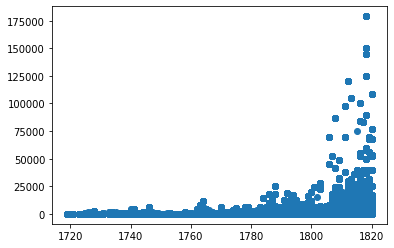

In [183]:
# Sale value doesn't really have outliers
plt.scatter(num_df['YEAR'],num_df['SALEVALP'])
plt.show()

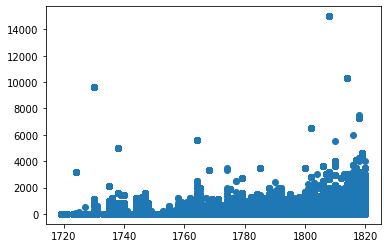

In [184]:
# Scatter plot showing inventory value vs year. Notice the outliers.
plt.scatter(num_df['YEAR'],num_df['INVVALP'])
plt.show()

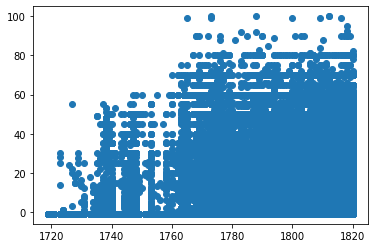

In [185]:
# Racial composition scatter plot shows a rapid increase in the age of those being sold
plt.scatter(num_df['YEAR'],num_df['AGE'])
plt.show()

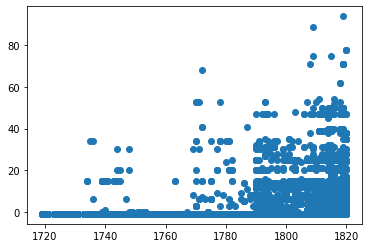

In [186]:
# Notice that slaves are going to more places as time goes on.
plt.scatter(num_df['YEAR'],num_df['WENT'])
plt.show()

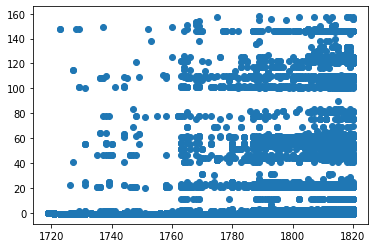

In [187]:
# More skills are added and slaves become more skilled overall as time goes on
# This should be normalized against the increase in overall transactions
# Why are there lots of new skills in the 1770s?
plt.scatter(num_df['YEAR'],num_df['SKILLCAT'])
plt.show()

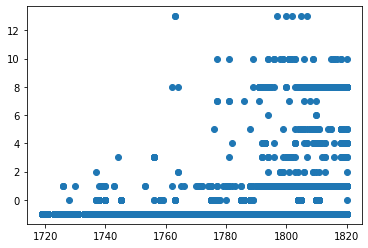

In [188]:
# Scatter plot showing distribution of character categories. Why are some added after 1780?
plt.scatter(num_df['YEAR'],num_df['CHARCAT'])
plt.show()

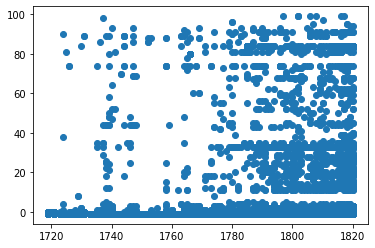

In [189]:
# Are the bands of illnesses around 1738, 177-something, indicative of epidemics?
plt.scatter(num_df['YEAR'],num_df['SICKCAT'])
plt.show()

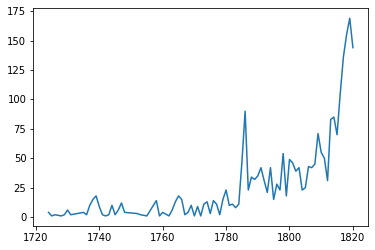

In [190]:
# Top 10 categories of sickness vs year
plt.plot(num_df['YEAR'].loc[num_df['SICKCAT']>0].value_counts().sort_index(),label="Sick persons sold at auction")
plt.show()
    


In [191]:
sicknesses = pd.Series(num_df['SICKCAT'].loc[num_df['SICKCAT']>0].value_counts())
sicknesses = sicknesses[sicknesses > 50]
sicknesses

33.0    471
1.0     223
84.0    192
3.0     136
2.0     113
74.0     71
12.0     64
18.0     61
4.0      53
11.0     51
Name: SICKCAT, dtype: int64

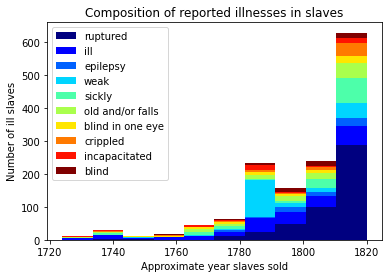

In [192]:
# Stacked histogram showing, for each year, the sicknesses of those sold at auction

jet = plt.cm.jet
colors = jet(np.linspace(0, 1, 10))

sick = num_df[num_df['SICKCAT']>0]
sick = sick[['YEAR','SICKCAT']]
plt.subplots()
s1 = sick['YEAR'].loc[sick['SICKCAT']==33]
s2 = sick['YEAR'].loc[sick['SICKCAT']==1]
s4 = sick['YEAR'].loc[sick['SICKCAT']==84]
s5 = sick['YEAR'].loc[sick['SICKCAT']==3]
s6 = sick['YEAR'].loc[sick['SICKCAT']==2]
s7 = sick['YEAR'].loc[sick['SICKCAT']==74]
s8 = sick['YEAR'].loc[sick['SICKCAT']==12]
s3 = sick['YEAR'].loc[sick['SICKCAT']==18]
s9 = sick['YEAR'].loc[sick['SICKCAT']==4]
s10 = sick['YEAR'].loc[sick['SICKCAT']==11]

plt.hist([s1,s2,s3,s4,s5,s6,s7,s8,s9,s10],10,color=colors,label=["ruptured","ill","epilepsy","weak","sickly","old and/or falls","blind in one eye","crippled","incapacitated","blind"],histtype='barstacked')

plt.title("Composition of reported illnesses in slaves")
plt.ylabel("Number of ill slaves")
plt.xlabel("Approximate year slaves sold")
plt.legend()
plt.show()

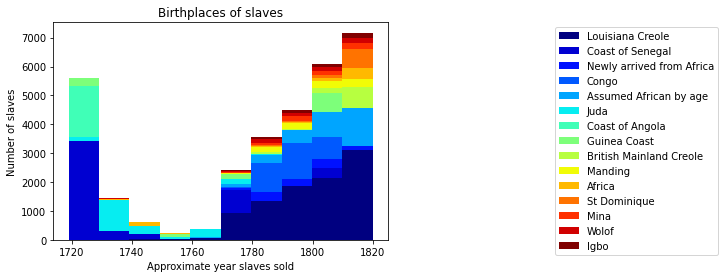

In [275]:
# Stacked histogram showing, for each year, the birthplace of those sold at auction

jet = plt.cm.jet
colors = jet(np.linspace(0, 1, 15))

sick = num_df[num_df['BIRTHPL']>0]
sick = sick[['YEAR','BIRTHPL']]
plt.subplots()
s1 = sick['YEAR'].loc[sick['BIRTHPL']==11]
s2 = sick['YEAR'].loc[sick['BIRTHPL']==115]
s4 = sick['YEAR'].loc[sick['BIRTHPL']==703]
s5 = sick['YEAR'].loc[sick['BIRTHPL']==551]
s6 = sick['YEAR'].loc[sick['BIRTHPL']==704]
s7 = sick['YEAR'].loc[sick['BIRTHPL']==498]
s8 = sick['YEAR'].loc[sick['BIRTHPL']==599]
s3 = sick['YEAR'].loc[sick['BIRTHPL']==199]
s9 = sick['YEAR'].loc[sick['BIRTHPL']==15]
s10 = sick['YEAR'].loc[sick['BIRTHPL']==103]
s11 = sick['YEAR'].loc[sick['BIRTHPL']==701]
s12 = sick['YEAR'].loc[sick['BIRTHPL']==35]
s13 = sick['YEAR'].loc[sick['BIRTHPL']==409]
s14 = sick['YEAR'].loc[sick['BIRTHPL']==106]
s15 = sick['YEAR'].loc[sick['BIRTHPL']==501]

plt.hist([s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15],color=colors,label=["Louisiana Creole","Coast of Senegal","Newly arrived from Africa","Congo","Assumed African by age","Juda","Coast of Angola","Guinea Coast","British Mainland Creole","Manding","Africa","St Dominique","Mina","Wolof","Igbo"],histtype='barstacked')

plt.title("Birthplaces of slaves")
plt.ylabel("Number of slaves")
plt.xlabel("Approximate year slaves sold")
plt.legend(bbox_to_anchor=(2,1))
plt.show()


In [265]:
sicknesses = pd.Series(num_df['BIRTHPL'].loc[num_df['BIRTHPL']>0].value_counts())
sicknesses = sicknesses[sicknesses > 500]
sicknesses

11.0     9461
115.0    5051
703.0    3116
551.0    3035
704.0    2039
498.0    1754
599.0    1264
199.0    1043
15.0      966
103.0     926
701.0     832
35.0      811
409.0     628
106.0     598
501.0     526
Name: BIRTHPL, dtype: int64

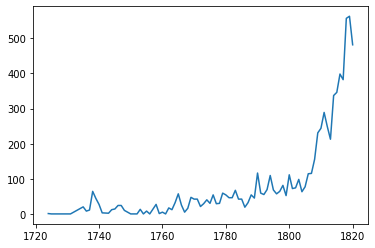

In [280]:
# Number of children sold with an adult per year
plt.plot(num_df['YEAR'].loc[num_df['CHILDREN']>0].value_counts().sort_index(),label="Sick persons sold at auction")
plt.show()

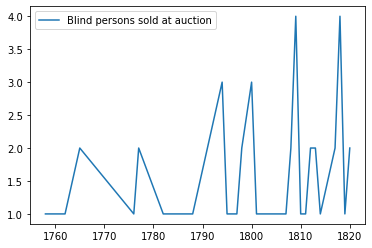

In [282]:
# Plot of the sick vs. year
plt.plot(num_df['YEAR'].loc[num_df['SICKCAT']==11].value_counts().sort_index(),label="Blind persons sold at auction")
plt.legend()
plt.show()

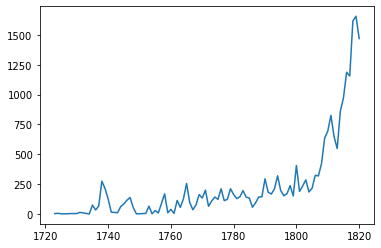

In [288]:
# Number of children sold with an adult per year

plt.plot(num_df['YEAR'].loc[num_df['FAMILY_Y_N']==1].value_counts().sort_index(),label="Person sold with their family")
plt.show()

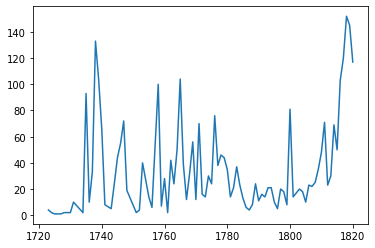

In [289]:
# Number of adults sold with spouse per year

plt.plot(num_df['YEAR'].loc[num_df['MATE']==1].value_counts().sort_index(),label="Person sold with their spouse")
plt.show()

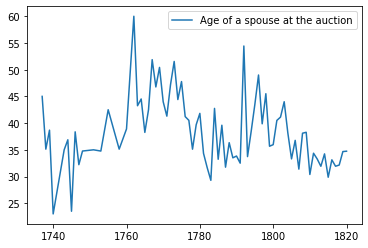

In [293]:
# Age of spouse change in years

plt.plot(num_df['AGEMATE'].loc[num_df['AGEMATE']>0].groupby(num_df['YEAR']).mean(),label="Average age of a spouse at the auction")
plt.legend()
plt.show()

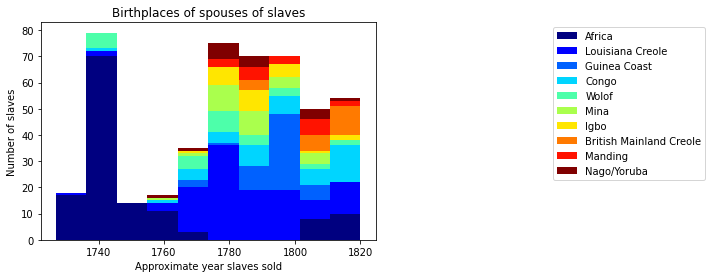

In [302]:
# Stacked histogram showing, for each year, the birthplace of those sold at auction

jet = plt.cm.jet
colors = jet(np.linspace(0, 1, 10))

originmate = num_df[num_df['ORIGINMATE']>0]
originmate = originmate[['YEAR','ORIGINMATE']]
plt.subplots()
s1 = originmate['YEAR'].loc[originmate['ORIGINMATE']==701]
s2 = originmate['YEAR'].loc[originmate['ORIGINMATE']==11]
s3 = originmate['YEAR'].loc[originmate['ORIGINMATE']==199]
s4 = originmate['YEAR'].loc[originmate['ORIGINMATE']==551]
s5 = originmate['YEAR'].loc[originmate['ORIGINMATE']==106]
s6 = originmate['YEAR'].loc[originmate['ORIGINMATE']==409]
s7 = originmate['YEAR'].loc[originmate['ORIGINMATE']==501]
s8 = originmate['YEAR'].loc[originmate['ORIGINMATE']==15]
s9 = originmate['YEAR'].loc[originmate['ORIGINMATE']==103]
s10 = originmate['YEAR'].loc[originmate['ORIGINMATE']==411]



plt.hist([s1,s2,s3,s4,s5,s6,s7,s8,s9,s10],color=colors,label=["Africa","Louisiana Creole","Guinea Coast","Congo","Wolof","Mina","Igbo","British Mainland Creole","Manding","Nago/Yoruba"],histtype='barstacked')

plt.title("Birthplaces of spouses of slaves")
plt.ylabel("Number of slaves")
plt.xlabel("Approximate year slaves sold")
plt.legend(bbox_to_anchor=(2,1))
plt.show()

In [296]:
num_df['ORIGINMATE'].loc[num_df['ORIGINMATE']>0].value_counts()

701.0    133
11.0     116
199.0     48
551.0     45
106.0     30
409.0     29
501.0     24
15.0      21
103.0     19
411.0     17
401.0     16
101.0     15
404.0     15
105.0     14
40.0       8
130.0      7
38.0       7
699.0      6
26.0       5
116.0      4
704.0      4
416.0      4
39.0       3
27.0       3
115.0      3
399.0      3
703.0      3
104.0      3
32.0       2
107.0      2
408.0      2
23.0       2
21.0       2
502.0      2
31.0       1
512.0      1
18.0       1
119.0      1
102.0      1
42.0       1
37.0       1
13.0       1
17.0       1
413.0      1
Name: ORIGINMATE, dtype: int64

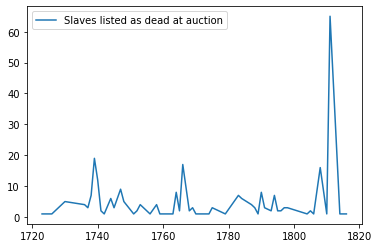

In [305]:
# Slaves sold dead at auction

plt.plot(num_df['YEAR'].loc[num_df['DEAD']==1].value_counts().sort_index(),label="Slaves listed as dead at auction")
plt.legend()
plt.show()

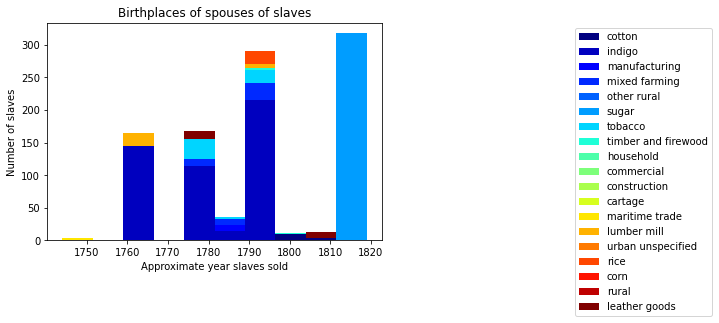

In [307]:

# Stacked histogram showing, for each year, the birthplace of those sold at auctiolumber mill,n
jet = plt.cm.jet
colors = jet(np.linspace(0, 1, 19))

originmate = num_df[num_df['ENTERPRISE']>0]
originmate = originmate[['YEAR','ENTERPRISE']]
plt.subplots()
s1 = originmate['YEAR'].loc[originmate['ENTERPRISE']==1]
s2 = originmate['YEAR'].loc[originmate['ENTERPRISE']==2]
s3 = originmate['YEAR'].loc[originmate['ENTERPRISE']==3]
s4 = originmate['YEAR'].loc[originmate['ENTERPRISE']==4]
s5 = originmate['YEAR'].loc[originmate['ENTERPRISE']==5]
s6 = originmate['YEAR'].loc[originmate['ENTERPRISE']==6]
s7 = originmate['YEAR'].loc[originmate['ENTERPRISE']==7]
s8 = originmate['YEAR'].loc[originmate['ENTERPRISE']==8]
s9 = originmate['YEAR'].loc[originmate['ENTERPRISE']==9]
s10 = originmate['YEAR'].loc[originmate['ENTERPRISE']==10]
s11 = originmate['YEAR'].loc[originmate['ENTERPRISE']==11]
s12 = originmate['YEAR'].loc[originmate['ENTERPRISE']==12]
s13 = originmate['YEAR'].loc[originmate['ENTERPRISE']==13]
s14 = originmate['YEAR'].loc[originmate['ENTERPRISE']==14]
s15 = originmate['YEAR'].loc[originmate['ENTERPRISE']==15]
s16 = originmate['YEAR'].loc[originmate['ENTERPRISE']==16]
s17 = originmate['YEAR'].loc[originmate['ENTERPRISE']==17]
s18 = originmate['YEAR'].loc[originmate['ENTERPRISE']==18]
s19 = originmate['YEAR'].loc[originmate['ENTERPRISE']==19]


plt.hist([s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19],color=colors,label=['cotton','indigo','manufacturing','mixed farming','other rural','sugar','tobacco','timber and firewood','household','commercial','construction','cartage','maritime trade','lumber mill','urban unspecified','rice','corn','rural','leather goods']
,histtype='barstacked')

plt.title("Birthplaces of spouses of slaves")
plt.ylabel("Number of slaves")
plt.xlabel("Approximate year slaves sold")
plt.legend(bbox_to_anchor=(2,1))
plt.show()

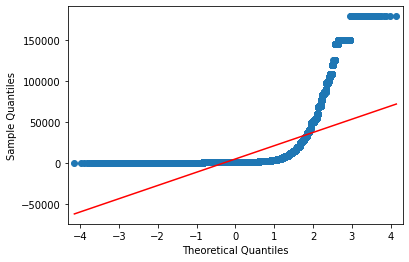

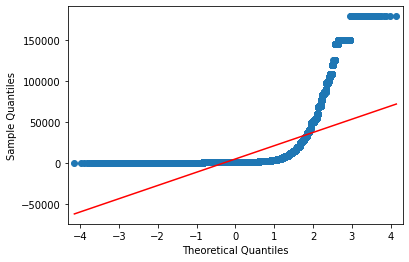

In [231]:
qqplot(df['SALEVALP'].loc[df['SALEVALP']>0], line='s')

In [ ]:
# Age distribution is also not Gaussian, as age rapidly declines above 30
plt.hist(num_df['AGE'])
plt.yscale("log")
plt.show()

In [ ]:
qqplot(df['AGE'].loc[df['AGE']>0], line='s')

In [ ]:
# Sex distribution has the problem that a bunch of genders are unknown
plt.hist(num_df['SEX'])
plt.show()

In [ ]:
qqplot(df['SEX'], line='s')

In [ ]:
# Distribution of location show strong preference for low number values
plt.hist(num_df['LOCATION'])
plt.yscale("log")
plt.show()

In [ ]:
qqplot(df['LOCATION'].loc[df['LOCATION']>0], line='s')

In [ ]:
# 3 is the code for New Orleans, which would be the outlier in the location field
num_df['LOCATION'].value_counts()

In [ ]:
# Docdate distribution shows maybe a power law distribution, but that dip in the 1740s-1770s has to be French/British relations
plt.hist(df['DOCDATE'])
plt.yscale("log")
plt.show()

In [ ]:
# Distribution of doctypes. 7 is normal sales, 1 is estates, 25 is Atlantic slave trade.
plt.hist(df['DOCTYPE'])

plt.show()

In [ ]:
qqplot(df['DOCTYPE'], line='s')

In [ ]:
df['DOCTYPE'].value_counts()

In [ ]:
# Distribution of slaves who were "maroons", i.e. runaways or escapees
# 1 is maroon, so 1070 maroons. Would be interesting to plot against year
plt.hist(num_df['MAROON'])
plt.show()

In [ ]:
num_df['MAROON'].value_counts()

In [ ]:
# Distribution of revolts, 312 revolts, would be interesting to plot against year and maroons
plt.hist(num_df['REVOLTS'])
plt.show()

In [ ]:
num_df['REVOLTS'].value_counts()

In [ ]:
df['AFLANG'].max()

In [ ]:
# Distribution of African languages, 12 is Benue-Congo
plt.hist(num_df['AFLANG'].loc[num_df['AFLANG'] > 0],bins=15)

plt.show()

In [ ]:
qqplot(df['AFLANG'].loc[df['AFLANG']>0], line='s')

In [ ]:
num_df['AFLANG'].value_counts()

In [ ]:
# Probably not worth printing the distribution of free persons involved, but would love
# to see plotted against year
num_df['FREE'].value_counts()

In [ ]:
df['SELLER'].value_counts()

In [ ]:
# Distribution of where slaves were sold to
plt.hist(num_df['WENT'].loc[df['WENT'] > 0])
plt.yscale("log")
plt.show()

In [ ]:
qqplot(num_df['WENT'].loc[df['WENT']>0], line='s')

In [ ]:
# Distribution of types of names
plt.hist(num_df['NAMETYPE'])
plt.show()

In [ ]:
# Unfortunate lack of African names
num_df['NAMETYPE'].value_counts()

In [ ]:
# Distribution of race
plt.hist(num_df['RACE'])
plt.show()

In [ ]:
# Distribution of the age categories, when ages are not listed
plt.hist(num_df['AGECATN'].loc[df['AGECATN']>0])
plt.show()

In [ ]:
qqplot(df['SALEVALP'].loc[df['SALEVALP']>0], line='s')

In [ ]:
df['AGECATN'].value_counts()

In [ ]:
# Distribution of the age categories, when ages are not listed
plt.hist(num_df['SKILLCAT'])
plt.show()

In [ ]:
qqplot(df['SKILLCAT'].loc[df['SKILLCAT']>0], line='s')

In [ ]:
# Distribution of skill categories
# 2=agricultural worker
# 21=domestic worker

num_df['SKILLCAT'].value_counts()

In [ ]:
# Distribution of experts
plt.hist(num_df['EXPERT'])
plt.show()

In [ ]:
# Distribution of experts
plt.hist(num_df['APPRENTICE'])
plt.show()

In [ ]:
num_df['APPRENTICE'].value_counts()

In [ ]:
# Distribution of experts
plt.hist(num_df['CHARCAT'].loc[num_df['CHARCAT']>0])
plt.show()

In [ ]:
# Highest characters: 1=good character, 1=runaway
num_df['CHARCAT'].value_counts()

In [ ]:
# Distribution of sicknesses
plt.hist(df['SICKCAT'].loc[df['SICKCAT']>0])
plt.show()

In [ ]:
qqplot(df['SICKCAT'].loc[df['SICKCAT']>0], line='s')

In [ ]:
# 33 = ruptured back
# 1 = ill
# 84 = epilepsy
# 3 = weak
# 2 = sickly
# 74 = old
# 12 = ringworm
# 18 = crippled

df['SICKCAT'].value_counts()[2:10]

In [ ]:
# Distribution of birthplaces
df['BIRTHPL'].sort_values()
plt.hist(num_df['BIRTHPL'].loc[df['BIRTHPL']>0])

plt.show()

In [ ]:
qqplot(df['BIRTHPL'].loc[df['BIRTHPL']>0], line='s')

In [ ]:
# Most common:
# 11=Louisiana Creole
# 115=Coast of Senegal
# 703=Recently landed from Africa
# 551=CONGO
# 704=Imputed African

num_df['BIRTHPL'].value_counts()[2:]

In [ ]:
# Distribution of inventory value
plt.hist(num_df['INVVALP'].loc[num_df['INVVALP'] > 0])
plt.yscale("log")
plt.show()

In [ ]:
qqplot(df['INVVALP'].loc[df['INVVALP']>0], line='s')

In [ ]:
num_df['INVVALP'].value_counts()[2:]

In [ ]:
# Distribution of sale values
plt.hist(num_df['SALEVALP'].loc[num_df['SALEVALP'] > 0])
# plt.yscale("log")
plt.xlabel("Inventory Value")
plt.ylabel("Number of transactions at inventory value")
plt.legend()
plt.show()

In [ ]:
num_df['INVVALP'].value_counts()[2:]

In [ ]:
# Distribution of mate/spouse of slave sold with slave
plt.hist(num_df['MATE'])

plt.show()

In [ ]:
num_df['MATE'].value_counts()

In [ ]:
# Distribution of the birthplace of spouse
plt.hist(num_df['ORIGINMATE'])

plt.show()

In [ ]:
num_df['ORIGINMATE'].value_counts()

In [ ]:
# Distribution of Emancipation
plt.hist(num_df['EMANCIP'])

plt.show()

In [ ]:
# Distribution of dead at sale
plt.hist(num_df['DEAD'])

plt.show()

In [ ]:
num_df['DEAD'].value_counts()

In [ ]:
# Distribution of runaways, log scale
plt.hist(num_df['RUNAWAY'])
plt.yscale("log")
plt.show()

In [ ]:
# 1 = actual runaway
# 2 = slave sheltered runaways
# 3 = slave testified against runaways
num_df['RUNAWAY'].value_counts()

In [ ]:
# Distribution of types of enterprises
# Most common:
# 6=sugar
# 7=tobacco
# 4=mixed farming

plt.hist(num_df['ENTERPRISE'].loc[num_df['ENTERPRISE'] > 0])
#plt.yscale("log")
plt.show()

In [ ]:
qqplot(df['ENTERPRISE'].loc[df['ENTERPRISE']>0], line='s')

In [ ]:
num_df['ENTERPRISE'].value_counts()[2:]

In [ ]:
# Distribution of stport (maritime trade embarkation)
# Most common:
# 83=Senegal
# 85=Bight of Benin
# 86=W Central Africa
# 51=Jamaica

plt.hist(num_df['STPORT'].loc[num_df['STPORT'] > 0])
#plt.yscale("log")
plt.show()

In [ ]:
num_df['STPORT'].value_counts()[1:]

In [ ]:
# Distribution of dead at sale
plt.hist(num_df['VIA'].loc[num_df['VIA'] > 0])
plt.show()

In [ ]:
qqplot(df['VIA'].loc[df['VIA']>0], line='s')

In [ ]:
num_df['VIA'].value_counts()[1:]

Why is there a huge discrepancy between VIA and STPORT?

In [ ]:
statistic, p_values = sc.stats.normaltest(num_df)

In [ ]:
statistic

In [ ]:
alpha = 0.05
for items in p_values:
    if items > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [ ]:
mean_df

In [ ]:
# Independent two-sided t test of years and sale value
year = num_df['YEAR']
year = year.astype('int')
age_salevalp_ttest_ind = sc.stats.ttest_ind(num_df['AGE'],num_df['SALEVALP'])
age_salevalp_ttest_rel = sc.stats.ttest_rel(num_df['AGE'],num_df['SALEVALP'])


In [ ]:
age_salevalp_ttest_ind

In [ ]:
age_salevalp_ttest_rel

In [ ]:
sex_salevalp_ttest_ind = sc.stats.ttest_ind(num_df['SEX'],num_df['SALEVALP'])
sex_salevalp_ttest_rel = sc.stats.ttest_rel(num_df['SEX'],num_df['SALEVALP'])

In [ ]:
sex_salevalp_ttest_ind

In [ ]:
sex_salevalp_ttest_rel

In [ ]:
stport_salevalp_ttest_ind = sc.stats.ttest_ind(num_df['STPORT'],num_df['SALEVALP'])
stport_salevalp_ttest_rel = sc.stats.ttest_rel(num_df['STPORT'],num_df['SALEVALP'])

In [ ]:
stport_salevalp_ttest_ind


In [ ]:
stport_salevalp_ttest_rel

In [ ]:
fast_details = ['GROUP','NAME','DATESALE','DOCDATE','SALEVALUE','SALEVALP','SEX','AGE','RACE']

In [ ]:
seller_details = ['SELLER','FIRST1','BUYER','FIRST2','SALECUR','WENT']

In [ ]:
value_piastre_2021_USD = 21.89

In [ ]:
df[fast_details].loc[df['SALEVALUE'] == 179000]

In [ ]:
df[seller_details].loc[df['SALEVALUE'] == 179000].value_counts()

In [ ]:
179000*value_piastre_2021_USD

In [ ]:
df[fast_details].loc[df['BUYER'] == 'Jourdan/Hoa'].count()

In [ ]:
# Per person sale for Jourdan/Hoa sale in 2021 USD
179000*value_piastre_2021_USD/90

In [ ]:
df[fast_details].loc[(df['SALEVALUE'] == 150000) & (df['SELLER'] == 'Notts')]

In [ ]:
df[seller_details].loc[(df['SALEVALUE'] == 150000) & (df['SELLER'] == 'Notts')].value_counts()

In [ ]:
df[seller_details].loc[(df['SALEVALUE'] == 150000) & (df['SELLER'] != 'Notts')].value_counts()

In [ ]:
df[fast_details].loc[(df['SALEVALUE'] == 150000) & (df['SELLER'] != 'Notts')]

In [ ]:
# Per person value of Chaipella sale
150000*value_piastre_2021_USD/70

In [ ]:
# Per person value of Notts sale
150000*value_piastre_2021_USD/80

In [ ]:
# Who the fuck is Paul Lanusse?
lanusse = df.loc[((df['SELLER'] == 'Lanusse') & (df['FIRST1'] == 'Paul')) |((df['BUYER'] == 'Lanusse')&(df['FIRST2'] == 'Paul')) ]

In [ ]:
lanusse_was_seller = lanusse.loc[lanusse['SELLER'] == 'Lanusse']
lanusse_was_buyer = lanusse.loc[lanusse['BUYER'] == 'Lanusse']
                                 

In [ ]:
lanusse_was_seller

In [ ]:
lanusse_was_buyer

In [ ]:
lanusse_was_seller['SALEVALP'].loc[lanusse_was_seller['DOCDATE'] < lanusse_was_buyer['DOCDATE'].iloc[0]]

In [ ]:
lanusse_sale_dates = lanusse_was_seller['DOCDATE'].value_counts().sort_index()

In [ ]:
lanusse_sale_dates

In [ ]:
lanusse_initial_sale = lanusse_was_seller.loc[lanusse_was_seller['DOCDATE'] < lanusse_was_buyer['DOCDATE'].iloc[0]]

In [ ]:
lanusse_initial_sale_value = lanusse_initial_sale['SALEVALP'].sum()*value_piastre_2021_USD

In [ ]:
lanusse_initial_purchase = lanusse_was_buyer.loc[lanusse_was_buyer['DOCDATE'] < lanusse_was_seller['DOCDATE'].iloc[3]]

In [ ]:
lanusse_initial_purchase

lanusse_initial_purchase_value = lanusse_initial_purchase['SALEVALP'].sum() * value_piastre_2021_USD

In [ ]:
lanusse_funds_after_initial_sale_and_purchase = lanusse_initial_sale_value-lanusse_initial_purchase_value

In [ ]:
lanusse_initial_sale_value

In [ ]:
lanusse_initial_purchase_value

In [ ]:
lanusse_funds_after_initial_sale_and_purchase

Tracing Lanusse manually is getting boring. Let's do it programmatically.

In [ ]:
def calc_

In [ ]:
correlation_df = num_df.corr().abs()

drop salevalue and inventory value since the valp methods are more accurate

In [ ]:
correlation_df = correlation_df.drop('SALEVALUE', axis=1)

In [ ]:
correlation_df = correlation_df.drop('SALEVALUE')

In [ ]:
correlation_df = correlation_df.drop('INVVALUE', axis=1)

In [ ]:
correlation_df = correlation_df.drop('INVVALUE')

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
correlation_df

In [ ]:
def explore_correlations(high_val, low_val):
    high_correlation = []
    for col in correlation_df:
        for index, value in correlation_df[col].items():

            if value > low_val and value < high_val:
                high_correlation.append([col, index, value])

    return high_correlation
explore_correlations(1,0.9)

High correlation between having grandchildren and being dead isn't surprised, as are all of the "grandparent" related columns being correlated with each other. However, a bit of a surprise is the emancipation column. It is strongly correlated with becoming a grandparent.

In [ ]:
explore_correlations(0.9,0.8)

In [ ]:
explore_correlations(0.8,0.7)

In [ ]:
explore_correlations(0.7,0.6)

In [ ]:
explore_correlations(0.6,0.5)

In [ ]:
normalized_df = pd.DataFrame(num_df.value_counts(normalize=True).abs())

In [ ]:
normalized_df

In [ ]:
z_score_df = sc.stats.zscore(num_df)

In [ ]:
z_score_df

In [ ]:
mean_df = num_df[num_df != -1].mean()

In [ ]:
mean_df

In [ ]:
median_df = num_df[num_df != -1].median()

In [ ]:
median_df

In [ ]:
mode_df = num_df[num_df != -1].mode()

In [ ]:
mode_df

In [ ]:
search_for_value(docdate, pd.to_datetime('1786-12-31'))

WOAH! 957 different records come from 1786, on the last day of the year. I have no clue why, at the moment. This points to some very strange issues with the data. How many records are clustered on a given day?

In [ ]:
docdate_occurrences = docdate.value_counts().astype('int')

In [ ]:
docdate_occurrences

This is a lot of data still to sift through. What I can see immediately is that some records come in clusters and some have only one entry. This points to very clumpy data. I need some way to sort out the two types of slave records, the low-intensity ones and the high-intensity ones. I am guesing that the dates with hundreds of entries are major auctions or otherwise memorable days. These should be grouped together and studied again. Similarly, the ones with just a few entires probably record much smaller scale, intimate interactions. I want to explore these two categories and compare them.

This leads to an absurd problem. At what point do we consider the sale of human beings "major" or "minor"? To those being trafficked, all sales are major. So, whatever value we choose is bound to be arbitrary. And, clearly, however we group these transactions, they are more than the dates the documents were written. There are human factors to consider. There is also, as it were, a sort of numerical simplicity to everything. We can use machine learning to clump transactions together and find commonalities. So with nearly barbaric simplicity, I am going to split the dataset I've collected into a numerical subset, and a non-numerical subset. The numerical subset will be easier to feed into the algorithms I have in mind for this experiment. The non-numerical subset is important to reintroduce the human element into all of this. But first, one last conclusion from the data exploration phase of this project.

In [ ]:
docdate_occurrences.median()

Based on the median value in the occurrences column, I can conclude that most of these documents record small transactions. This is, I suppose, not very surprising. I would suspect most slaveholding transactions were oddly personal for something so dehumanizing. Probably if you plotted the sale of dogs or cows even in the present day you'd see the same disparity between small transactions and gigantic transactions.

In [ ]:
names = [col for col in df.columns]

In [ ]:
names

Time for some more data cleaning. The original project left a series of numeric codes for a bunch of columns. The only problem is that they simply left some entries blank if they didn't know the answer. I can't have blank entries for my later analysis. So, I need to get rid of the blanks. 

Let's start with the DOCNO column. The team used document number from the documents. Do I really need this in later analysis? No.

In [ ]:
df = df.drop(columns=['LOCATION', 'LINGUISTIC','NAMEXPLAIN'])  #DOCNO, CODER, DEPOT, LINGUISTIC

In [ ]:
df['PREGNANT'] = df['PREGNANT'].fillna(0) # AGECATN, AGE, RACE, SEX, NAMETYPE, WENT, ESTATEPOP, ESTATE, ESTATEFREE, FREE, AFLANG, Language, Notary, Maroon, REVOLTS

In [ ]:
df['INVVALUE'] = df['INVVALUE'].replace(to_replace='Z', value = 'UNKNOWN') # SKILLS, NAME, FIRST2, BUYER, FIRST1, SELLER, ESTATE_OF

In [ ]:
compression_opts = dict(method='zip',

                        archive_name='out.csv')  

df.to_csv('out.zip', index=False,

          compression=compression_opts)  

In [ ]:
df['ISLAMIC'].iloc[df['ISLAMIC'].first_valid_index()]

In [ ]:
df.loc[:,df.isna().any()]

In [ ]:
number_col = df.select_dtypes(include='number')

In [ ]:
number_col

In [ ]:
number_col_names = [col for col in number_col.columns]
number_col_names

In [ ]:
number_col_names = [col for col in number_col.columns]

In [ ]:
number_col = number_col.drop(columns=['DEPOT','PREGNANT','DOCNO','CODER','REVOLTS','LINGUISTIC'])

In [ ]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [ ]:
kmeans = KMeans(
        init="random",
        n_clusters=2,
        n_init=10,
        max_iter=300,
        random_state=42
    )

In [ ]:
# Create a new dataframe with enterprise, age, salevalp, invalp, sex and race
auction_value = pd.concat([number_col['ENTERPRISE'],number_col['AGE'],number_col['SALEVALP'],number_col['INVVALP'],number_col['SEX'],number_col['RACE']],axis=1)

In [ ]:
auction_value

In [ ]:

scaled_value = scaler.fit_transform(auction_value)

In [ ]:
kmeans.fit(scaled_value)

In [ ]:
kmeans_silhouette = silhouette_score(scaled_value, kmeans.labels_).round(2)


In [ ]:
kmeans_silhouette

In [ ]:
# Plot the data and cluster silhouette comparison
fig, (ax1) = plt.subplots(
    1, figsize=(8, 6), sharex=True, sharey=True)

fig.suptitle(f"Pregnancy Cluster To Demographic Factors in Slavetrading 1721-1820", fontsize=16)
fte_colors = {
    0: "#008fd5",
    1: "#fc4f30",}
# The k-means plot
km_colors = [fte_colors[label] for label in kmeans.labels_]
ax1.scatter(scaled_number_col[:, 0], scaled_number_col[:, 1], c=km_colors)
ax1.set_title(
    f"k-means\nSilhouette: {kmeans_silhouette}", fontdict={"fontsize": 12})

plt.show()

Let's take the mean and standard deviation of the years column.

In [ ]:
df = pd.read_csv("out.csv")

Here's something weird. If you run a simple Pearson's ranking between the year column and the df['DEAD'] column, there's a negative correlation. It's rather slight, but this indicates that as the years went on, slaves were less likely to be sold as part of an estate sale.

Similarly, there's an ever-so-slight correlation between listing a slave auction as part of an estate sale, and the sale of expert workers.

In [ ]:
dead_expert_correlation = dead.corr(expert)
dead_expert_correlation

There is practically no correlation between listing someone as an apprentice (i.e. not skilled) and estate sales.

In [ ]:
dead_apprentice_correlation = dead.corr(apprentice)
dead_apprentice_correlation

In [ ]:
def count_items_statistical_significance(column, exclude_list):
    '''
    Method to count items specifically for statistical significance. The reason I'm not
    using in-built methods is because I want to exclude certain values.
    
    Column is just a string name for the DataFrame column, but exclude list has to be a list.
    '''
    if type(exclude_list) is not list:
        error_message = "The exclude list must be a list, and only one level"
        return error_message
    counter = 0
    for index, value in df[column.upper()].items():
        if value not in exclude_list:
            counter += 1
    return counter

In [ ]:
# How many experts are there in the dataset?
print(count_items_statistical_significance('EXPERT',[-1,0]))

# How many apprentices are there in the dataset?
print(count_items_statistical_significance('apprentice',[-1,0]))

df['APPRENTICE'].median()

How are there 1191 experts but only 26 apprentices? Isn't an apprentice a step in the journey to being an expert? Is this price-gouging? Is this industry specific? 

In [ ]:
def count_column1_with_respect_to_column2(col1, col2_value, col2):
    '''
        Counts how many entries in column 1 have a specific entry in column 2 and returns a 
    list with the count and the indices. However, this one just pulls all values that are 
    NOT in a certain range.
    
    Requires a list as col2_value.
    '''
    positives = []

    if col1 == col2:
        for index, value in df[col1.upper()].items():
            if df[col1.upper()].iloc[index] in col2_value:
                positives.append(index)
    for index, value in df[col1.upper()].items():
        if df[col2.upper()].iloc[index] in col2_value:
            positives.append(index)

    return [len(positives), positives]

In [ ]:
def clump_yparam(dist_list, y_param, x_param = 'YEAR'):
    '''
    It is helpful to figure out what year a specific column tends to clump by.
    '''
    dict_returned = {}
    for entries in dist_list[1]:
        year = str(df[x_param.upper()].iloc[entries])
        if year in dict_returned and df[y_param].iloc[entries] > 0:
            dict_returned[year] += 1

        elif df[y_param].iloc[entries] > 0 and year not in dict_returned:
            dict_returned[year] = 1
    return dict_returned

def clump_filtered_yparam(dist_list, y_param, x_param = 'YEAR'):
    
    '''
    Instead of giving a total persons for the year, this one returns the average value
    '''
    dict_returned = {}
    for entries in dist_list[1]:
        year = str(df[x_param.upper()].iloc[entries])
        if year in dict_returned and df[y_param].iloc[entries] > 0:
            dict_returned[year].append(float(df[y_param.upper()].iloc[entries]))

        elif df[y_param].iloc[entries] > 0 and year not in dict_returned:
            dict_returned[year] = [float(df[y_param.upper()].iloc[entries])]
    for years in dict_returned:
        dict_returned[years] = statistics.mean(dict_returned[years])
    return dict_returned

Why does the sale of experts increase so much in the 1810s? Is it significant that this is after the law banning importation of slaves? The standard deviation is nearly thirty.

So something changed in the early 19th century. Can we find that exact pivot? I want to plot the years on the y axis and the number of expert slaves sold on the x axis.

So apprentices seem to have sold at a spiky but consistent rate, with a tiny uptick in the 1810s. But experts sold exponentially more often after 1790, and especially after 1800. Why were so many experts being sold but not apprentices?

In [ ]:
def plot_col1_against_col2_by_year(y_param, xlabel, ylabel, filter_values, x_param = 'YEAR', filter_param = 'YEAR'):
    '''
    Plots the frequency of col2's sale against years (default) or any other column (optional)
    Col2: string
    Col2_values: list
    xlabel, ylabel, col1: strings
    '''

    # Figure out how often col2 occurs and how it is distributed across col3's values
    if filter_param == 'YEAR':
        distribution_list = count_column1_with_respect_to_column2(y_param.upper(), filter_values, y_param)
        frequency_dict = clump_yparam(distribution_list, y_param.upper(), x_param.upper())
    else:
        distribution_list = count_column1_with_respect_to_column2(y_param.upper(), filter_values, filter_param.upper())
        frequency_dict = clump_filtered_yparam(distribution_list, y_param.upper(), x_param.upper())
    # Change into a frequency calculation

    x_axis = []
    y_axis = []
    for year, total_count in frequency_dict.items():
        x_axis.append(year)
        y_axis.append(total_count)

    # Plot a line graph 
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(xlabel + ' vs ' + ylabel)

    plt.plot(x_axis, y_axis)

    plt.show()
    
    print("Correlation between ",filter_param," and ",y_param,": ",df[filter_param.upper()].corr(df[y_param.upper()]))
    print("Standard deviation between", y_param," filtered on", filter_param,": ",statistics.pstdev(y_axis))
    print("Median value of",y_param,"filtered on", filter_param,filter_values,": ", statistics.median(y_axis))

    

In [ ]:
# Women = 1 on SEX category
plot_col1_against_col2_by_year('INVVALP', 'Year', 'Total inventory value of women sold',[1],'YEAR','SEX')
plot_col1_against_col2_by_year('SALEVALP', 'Year', 'Total sale value of women sold',[1],'YEAR', 'SEX')

plot_col1_against_col2_by_year('INVVALP', 'Year', 'Total inventory value of Pregnant persons',[1],'YEAR','PREGNANT')

In [ ]:
plot_col1_against_col2_by_year('SEX','Year','Women sold into slavery',[1] )
plot_col1_against_col2_by_year('SEX','Year','Men sold into slavery',[2])
plot_col1_against_col2_by_year('APPRENTICE','Year','Number of apprentices sold',[1])

In [ ]:
plot_col1_against_col2_by_year('INVVALP', 'Year', 'Inventory value of expert slaves',[-1,0],'YEAR','EXPERT')

plot_col1_against_col2_by_year('INVVALP', 'Year','Inventory value of non-expert slaves',[1],'YEAR', 'EXPERT')
plot_col1_against_col2_by_year('SALEVALP', 'Year', 'Sale value of expert slaves', [-1,0], 'YEAR', 'EXPERT')
plot_col1_against_col2_by_year('SALEVALP', 'Year', 'Sale value of non-expert slaves', [1], 'YEAR', 'EXPERT')


In [ ]:
plot_col1_against_col2_by_year('INVVALP', 'Year', 'Inventory value of apprenticed slaves',[-1,0],'YEAR','APPRENTICE')
plot_col1_against_col2_by_year('INVVALP', 'Year', 'Inventory value of non-apprenticed slaves',[1],'YEAR', 'APPRENTICE')
plot_col1_against_col2_by_year('SALEVALP','Year', 'Sale value of apprenticed slaves',[-1,0],'YEAR','APPRENTICE')
plot_col1_against_col2_by_year('SALEVALP','Year', 'Sale value of non-apprenticed slaves',[1],'YEAR', 'APPRENTICE')

In [ ]:
# Women = 1 on SEX category
plot_col1_against_col2_by_year('INVVALP', 'Year', 'Inventory value of women',[-1,0,2,9],'YEAR','SEX')
plot_col1_against_col2_by_year('INVVALP', 'Year', 'Inventory value of non-women',[1],'YEAR', 'SEX')
plot_col1_against_col2_by_year('SALEVALP','Year', 'Sale value of women',[-1,0,2,9],'YEAR','SEX')
plot_col1_against_col2_by_year('SALEVALP','Year', 'Sale value of non-women',[1],'YEAR', 'SEX')

In [ ]:
# Women = 1 on SEX category
plot_col1_against_col2_by_year('INVVALP', 'Year', 'Inventory value of unidentified gender',[-1,0,2,9],'YEAR','SEX')
plot_col1_against_col2_by_year('SALEVALP', 'Year', 'SALE value of identified gender',[-1,0,2,9],'YEAR', 'SEX')

plot_col1_against_col2_by_year('INVVALP', 'Year', 'Inventory value of Pregnant persons',[-1,0,2,9],'YEAR','PREGNANT')


In [ ]:
# Men = 2 on SEX category
plot_col1_against_col2_by_year('INVVALP', 'Year', 'Total inventory value of men sold',[-1,0,1,9],'YEAR','SEX')
plot_col1_against_col2_by_year('SALEVALP', 'Year', 'Total sale value of men sold',[-1,0,1,9],'YEAR', 'SEX')